# Plot results and make tables

This notebook can be used as a guide to on how to read in the data and plot some figures. It is a working file and can be run as is, or can be used to understand what is in the hdf5 files outputted by the run_hybrid_MC.py and the hybrid_LCAIO class object. However it should be clear that this is no cleaned code, merely to be used as a helping guide or to produce some figures.

In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.append('/home/jakobs/Documents/IndEcol/OASES/ecospold2matrix/')
sys.path.append('/home/jakobs/Documents/IndEcol/OASES/pymrio/')
sys.path.append('/home/jakobs/Documents/IndEcol/OASES/pylcaio/src/')
import ecospold2matrix as e2m
import pymrio
import pylcaio

sys.path.append('/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/scripts')
from aggregate import build_MultiIndex_Aggregation_Matrix, Aggregation_dic_from_file

import hybrid_lcaio

import os
import gzip
import pickle
import pandas as pd

from importlib import reload
import pdb
import scipy.sparse
from pypardiso import spsolve, factorized
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.stats as stats
import time
import numba
import json
import ray
import random
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec


from hybrid_lcaio import Hybrid_LCAIO
import h5py

from matplotlib import rc
#sns.set()
rc('font',**{'family':'DejaVu Sans', 'size':18})                                            
rc('text', usetex=True)


# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })
import tikzplotlib



## Open hdf5 files:

In [2]:
data_dir = '/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/Databases/'

In [3]:
# Files with truncation errors
f = h5py.File(os.path.join(data_dir,
                           'Results_geography_MC_BACI_price_10000_runs_3FPs_ProdVolWeights_constantprice_False_ecoinventprice_False_constant_region_False_only_Cu_impacts.hdf5'))
h = h5py.File(os.path.join(data_dir,
                           'Results_geography_MC_BACI_price_10000_runs_3FPs_ProdVolWeights_constantprice_mean_True_ecoinventprice_False_constant_region_False_only_Cu_impacts.hdf5'))
g = h5py.File(os.path.join(data_dir,
                           'Results_geography_MC_BACI_price_10000_runs_3FPs_ProdVolWeights_constantprice_False_ecoinventprice_False_constant_region_True_only_Cu_impacts.hdf5'))


In [4]:
# Files with L matrix impacts 
f_L = h5py.File(os.path.join(data_dir, 'Results_geography_MC_BACI_price_10000_runs_3FPs_ProdVolWeights_constantprice_False_ecoinventprice_False_constant_region_False.hdf5'))
h_L = h5py.File(os.path.join(data_dir, 'Results_geography_MC_BACI_price_10000_runs_3FPs_ProdVolWeights_constantprice_mean_True_ecoinventprice_False_constant_region_False.hdf5'))
g_L = h5py.File(os.path.join(data_dir, 'Results_geography_MC_BACI_price_10000_runs_3FPs_ProdVolWeights_constantprice_False_ecoinventprice_False_constant_region_True.hdf5'))
                

In [ ]:
del f_L
del g_L
del h_L

### Check file contents

In [5]:
h.visititems(print)

io_impacts <HDF5 group "/io_impacts" (3 members)>
io_impacts/Global Warming Potential 100 <HDF5 dataset "Global Warming Potential 100": shape (10000, 16022), type "<f8">
io_impacts/Land use <HDF5 dataset "Land use": shape (10000, 16022), type "<f8">
io_impacts/Water Consumption Blue - Total <HDF5 dataset "Water Consumption Blue - Total": shape (10000, 16022), type "<f8">
lca_impacts <HDF5 dataset "lca_impacts": shape (879, 16022), type "<f8">


In [6]:
for item in f.attrs.items():
    print(item)

('Name', 'Hybrid (MRIO) impacts for ecoinvent 3.5 and EXIOBASE 3.6')
('Price data', 'BACI, where possible, rest modelled as described in DOI: 10.3389/frsus.2021.666209')
('date created', 'Sun Oct 31 07:28:40 2021')
('hdb_file_name', '/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/Databases/HDB_STAM.pickle')


In [7]:
f['io_impacts/Global Warming Potential 100'].shape

(10000, 16022)

### Open hybrid database object

In [8]:
%%time
with open('/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/Databases/HDB_STAM.pickle', 'rb') as fh:
    hdb = pd.read_pickle(fh)  # pickle.load(fh) # there's a bug in pandas 1.3.0 therefore use pd.read_pickle instead

CPU times: user 8.48 s, sys: 3.77 s, total: 12.3 s
Wall time: 12.9 s


### check contents

In [9]:
hdb.__class__

hybrid_lcaio.Hybrid_LCAIO

In [10]:
dir(hdb)

['A_io',
 'A_lca',
 'C_io',
 'C_lca',
 'F_io',
 'F_lca',
 'Fixed_geo_concordance',
 'H',
 'L_lca',
 'MC_results_file',
 'M_io',
 'Nreg',
 'NregionSecotrs_io',
 'Nsec',
 'PRO',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'build_price_dictionary',
 'build_priceless_Cu',
 'build_uncorrected_priceless_Cu',
 'calc_L_lca',
 'calc_M_io',
 'calc_lca_impacts',
 'correction_matrix_STAM',
 'countries_per_region',
 'country_industry_IO_mapping',
 'create_Cu',
 'dictRoW',
 'double_counting',
 'generate_country_vector',
 'get_column_indices',
 'get_region_and_price',
 'get_variable_price',
 'hybridized_processes',
 'hybridized_processes_boolean_mask',
 'impact_names_io',
 'io_re

In [11]:
hdb.C_lca

<879x4243 sparse matrix of type '<class 'numpy.float64'>'
	with 219465 stored elements in Compressed Sparse Row format>

### Make some grouping filters based on regional aggregation and CPC section (product classification)

In [12]:
#  Load in region mapping
with open('/home/jakobs/Documents/IndEcol/OASES/mappings/ecoinvent35-baci_region_mapping.json', 'r') as fh:
    eco_baci_region_mapping_dic = json.load(fh)

In [13]:
#  Get list of single country and aggregate regions
single_countries = []
aggregate_regions = []
for key in eco_baci_region_mapping_dic.keys():
    if len(key.split('_')) == 1:
        if key != 'GLO':
            if len(eco_baci_region_mapping_dic[key]) == 1:
                single_countries.append(key)
            elif len(eco_baci_region_mapping_dic[key]) >= 2:
                aggregate_regions.append(key)

In [14]:
# Define masks for Global, RoW, aggregate N>5, aggregate N<= 5 and single country processes
GLO_bool_mask = hdb.PRO.geography.isin(['GLO']).values
RoW_bool_mask = hdb.PRO.geography.isin(['RoW']).values
RER_bool_mask = hdb.PRO.geography.isin(['RER']).values
Aggregate_bool_mask = hdb.PRO.geography.isin(aggregate_regions).values
SiC_bool_mask = hdb.PRO.geography.isin(single_countries).values
all_aggregate_bool_mask = ~hdb.PRO.geography.isin(single_countries).values

In [15]:
BACI_hybrid_list_booolean_mask = hdb.PRO.index.isin(hdb.processes_with_baci_price)

In [16]:
#  Get masks for CPC catergories
#  sort by first digit (class)
#  Section 0: Agriculture forestry and fishery products
section0_bool_mask = hdb.PRO.cpc.str.split(':').str.get(0).str.startswith('0')
section0_bool_mask[section0_bool_mask.isnull()] = False
section0_bool_mask = section0_bool_mask.values
#  Section 1: Ores and minerals; electricity, gas and water
section1_bool_mask = hdb.PRO.cpc.str.split(':').str.get(0).str.startswith('1')
section1_bool_mask[section1_bool_mask.isnull()] = False
section1_bool_mask = section1_bool_mask.values
#  Section 2: Food products, beverages amd tabacos; textiles apparel and leather products
section2_bool_mask = hdb.PRO.cpc.str.split(':').str.get(0).str.startswith('2')
section2_bool_mask[section2_bool_mask.isnull()] = False
section2_bool_mask = section2_bool_mask.values
#  Section 3: Other transportable goods, except metal products, machinery and equipment
section3_bool_mask = hdb.PRO.cpc.str.split(':').str.get(0).str.startswith('3')
section3_bool_mask[section3_bool_mask.isnull()] = False
section3_bool_mask = section3_bool_mask.values
#  Section 4: Metal products, machinery and equipment
section4_bool_mask = hdb.PRO.cpc.str.split(':').str.get(0).str.startswith('4')
section4_bool_mask[section4_bool_mask.isnull()] = False
section4_bool_mask = section4_bool_mask.values

## Plot some metrics and make tables

The rest of the notebook below was used to generate figures and tables. Its not cleaned up but can be run as is. 



In [17]:
# Define some colours for plotting
c = ['#66c2a5','#fc8d62','#8da0cb']

In [12]:
def offset_violinplot_halves(ax, delta, width, inner, direction):
    """
    This function offsets the halves of a violinplot to compare tails
    or to plot something else in between them. This is specifically designed
    for violinplots by Seaborn that use the option `split=True`.

    For lines, this works on the assumption that Seaborn plots everything with
     integers as the center.

    Args:
     <ax>    The axis that contains the violinplots.
     <delta> The amount of space to put between the two halves of the violinplot
     <width> The total width of the violinplot, as passed to sns.violinplot()
     <inner> The type of inner in the seaborn
     <direction> Orientation of violinplot. 'hotizontal' or 'vertical'.

    Returns:
     - NA, modifies the <ax> directly
    """
    # offset stuff
    if inner == 'sticks':
        lines = ax.get_lines()
        for line in lines:
            if direction == 'horizontal':
                data = line.get_ydata()
                print(data)
                if int(data[0] + 1)/int(data[1] + 1) < 1:
                    # type is top, move neg, direction backwards for horizontal
                    data -= delta
                else:
                    # type is bottom, move pos, direction backward for hori
                    data += delta
                line.set_ydata(data)
            elif direction == 'vertical':
                data = line.get_xdata()
                print(data)
                if int(data[0] + 1)/int(data[1] + 1) < 1:
                    # type is left, move neg
                    data -= delta
                else:
                    # type is left, move pos
                    data += delta
                line.set_xdata(data)


    for ii, item in enumerate(ax.collections):
        # axis contains PolyCollections and PathCollections
        if isinstance(item, matplotlib.collections.PolyCollection):
            # get path
            path, = item.get_paths()
            vertices = path.vertices
            half_type = _wedge_dir(vertices, direction)
            # shift x-coordinates of path
            if half_type in ['top','bottom']:
               if inner in ["sticks", None]:
                    if half_type == 'top': # -> up
                        vertices[:,1] -= delta
                    elif half_type == 'bottom': # -> down
                        vertices[:,1] += delta
            elif half_type in ['left', 'right']:
                if inner in ["sticks", None]:
                    if half_type == 'left': # -> left
                        vertices[:,0] -= delta
                    elif half_type == 'right': # -> down
                        vertices[:,0] += delta

def _wedge_dir(vertices, direction):
    """
    Args:
      <vertices>  The vertices from matplotlib.collections.PolyCollection
      <direction> Direction must be 'horizontal' or 'vertical' according to how
                   your plot is laid out.
    Returns:
      - a string in ['top', 'bottom', 'left', 'right'] that determines where the
         half of the violinplot is relative to the center.
    """
    if direction == 'horizontal':
        result = (direction, len(set(vertices[1:5,1])) == 1)
    elif direction == 'vertical':
        result = (direction, len(set(vertices[-3:-1,0])) == 1)
    outcome_key = {('horizontal', True): 'bottom',
                   ('horizontal', False): 'top',
                   ('vertical', True): 'left',
                   ('vertical', False): 'right'}
    # if the first couple x/y values after the start are the same, it
    #  is the input direction. If not, it is the opposite
    return outcome_key[result]

In [18]:
masklist = [BACI_hybrid_list_booolean_mask,
            np.logical_and(BACI_hybrid_list_booolean_mask, all_aggregate_bool_mask),
            np.logical_and(BACI_hybrid_list_booolean_mask, GLO_bool_mask),
            np.logical_and(BACI_hybrid_list_booolean_mask, RoW_bool_mask),
            np.logical_and(BACI_hybrid_list_booolean_mask, Aggregate_bool_mask),
            np.logical_and(BACI_hybrid_list_booolean_mask, SiC_bool_mask),
            np.array(np.logical_and(BACI_hybrid_list_booolean_mask, section0_bool_mask), dtype=bool),
            np.array(np.logical_and(BACI_hybrid_list_booolean_mask, section1_bool_mask), dtype=bool),
            np.array(np.logical_and(BACI_hybrid_list_booolean_mask, section2_bool_mask), dtype=bool),
            np.array(np.logical_and(BACI_hybrid_list_booolean_mask, section3_bool_mask), dtype=bool),
            np.array(np.logical_and(BACI_hybrid_list_booolean_mask, section4_bool_mask), dtype=bool)
            ]
mask_names_it = ['All', 'All agg. reg.', '{\it Global}', '{\it Rest of World}', '{\it Other agg. reg.}' , 'Single Countries', 'CPC section 0', 'CPC section 1', 
             'CPC section 2', 'CPC section 3', 'CPC section 4']

mask_names = ['All', 'All agg. reg.', 'Global', 'Rest of World', 'Other agg. reg.' , 'Single Countries', 'CPC section 0', 'CPC section 1', 
             'CPC section 2', 'CPC section 3', 'CPC section 4']

col_names = 'Subset & $N_\mathrm{proc}$ & rMAD \\\\'


In [11]:
def violin_plots(f,h, f_name, h_name, masklist, mask_names, col_names, c, fu_multiplier=None, save_fig=False):
    mask_lens = [sum(mask) for mask in masklist]
    tick_labels = [x+'  ' for (x,mask) in zip(mask_names, masklist)]
    
    lw = 1
    elw = 1.
    cs = 1.5
    offset=0.035
    sns.set_color_codes()
    #c = ['#66c2a5','#fc8d62','#8da0cb']


    for j,(dataset_var, dataset_fix) in enumerate(zip(f['io_impacts'].items(),h['io_impacts'].items())):
        # assert that itis the same impact category
        assert dataset_var[0]==dataset_fix[0]
        
        # get the data for io impacts with variable and fixed price
        if isinstance(fu_multiplier, np.ndarray):
            io_impacts_var = np.einsum('ij,j->ij', dataset_var[1][()], fu_multiplier).T
            io_impacts_fix = np.einsum('ij,j->ij', dataset_fix[1][()], fu_multiplier).T
            print(io_impacts_var.shape)
        else:
            io_impacts_var = dataset_var[1][()].T
            io_impacts_fix = dataset_fix[1][()].T
        impacts_name = dataset_var[0]
        
        print(impacts_name)
        
        fig  = plt.figure(j, figsize=(6,8))
        supax = fig.add_subplot(111)
        ax = fig.add_subplot(153)
        ax2 = fig.add_subplot(143)
        ax3 = fig.add_subplot(122)
        ypositions = np.linspace(1,len(mask_names),len(mask_names))[::-1]-1
        
        list_of_rmads = []
        list_of_rmads_fp = []
        data_df = pd.DataFrame(columns=[' ', 'Prices', 'rMAD', 'CoV'])
        
        for i,(mask,mask_name) in enumerate(zip(masklist, mask_names)):
            #lca_impact = impacts_lca_samples_CH_HH[4,ma].sum()
            # io_impact_eco_price = impacts_io_price_from_pylcaio[4,mask].sum()
            
            rMAD = np.nan_to_num(scipy.stats.median_abs_deviation(io_impacts_var[mask,:], axis=1)/
                                    np.abs(np.nanmedian(io_impacts_var[mask,:], axis=1)))
            # Line above: Take absolut value in case of negative final demand multipliers as we are interested in the variance, not the sign
            percentiles_rMAD = np.percentile(rMAD, [2.5,16,50,84,97.5])        
        
            list_of_rmads.append(rMAD)
            
            ax3.errorbar(percentiles_rMAD[2], ypositions[5-i]-offset,
                         xerr=np.array([[percentiles_rMAD[2]-percentiles_rMAD[0],
                                         percentiles_rMAD[-1]-percentiles_rMAD[2]]]).T, c='k', lw=lw, elinewidth=elw, capsize=cs, zorder=5)
            ax3.errorbar(percentiles_rMAD[2], ypositions[5-i]-offset,
                         xerr=np.array([[percentiles_rMAD[2]-percentiles_rMAD[1],
                                         percentiles_rMAD[-2]-percentiles_rMAD[2]]]).T, c=c[0], fmt='+', lw=lw, elinewidth=elw, capsize=cs, zorder=10)
        
            ###############################################################################################################################################
        
            rMAD_fixed_price = np.nan_to_num(scipy.stats.median_abs_deviation(io_impacts_fix[mask,:], axis=1)/
                                    np.abs(np.nanmedian(io_impacts_fix[mask,:], axis=1)))
            # Line above: Take absolut value in case of negative final demand multipliers as we are interested in the variance, not the sign            
            percentiles_rMAD_fp = np.percentile(rMAD_fixed_price, [2.5,16,50,84,97.5])
           
            list_of_rmads_fp.append(rMAD_fixed_price)
            
            ax3.errorbar(percentiles_rMAD_fp[2], ypositions[5-i]+offset,
                         xerr=np.array([[percentiles_rMAD_fp[2]-percentiles_rMAD_fp[0],
                                         percentiles_rMAD_fp[-1]-percentiles_rMAD_fp[2]]]).T, c='k', ls='--', lw=lw, elinewidth=elw, capsize=cs, zorder=5)
            ax3.errorbar(percentiles_rMAD_fp[2], ypositions[5-i]+offset,
                         xerr=np.array([[percentiles_rMAD_fp[2]-percentiles_rMAD_fp[1],
                                         percentiles_rMAD_fp[-2]-percentiles_rMAD_fp[2]]]).T, c=c[1], fmt='+', ls='--', lw=lw, elinewidth=elw, capsize=cs, zorder=10)

            for i,j in zip(rMAD,rMAD_fixed_price):
                data_df = data_df.append({' ':mask_name, 'Included Variance':f_name, 'rMAD':i}, ignore_index=True)
                data_df = data_df.append({' ':mask_name, 'Included Variance':h_name, 'rMAD':j}, ignore_index=True)
                            

        width = 0.67
        delta = 0.11
        final_width = width - delta
        inner = None
        output = sns.violinplot(data=data_df, y=' ', x='rMAD', hue='Included Variance', ax=ax3, palette={f_name: c[0], h_name: c[1]},
                                zorder=0, split=True, inner=inner, width=width,
                                linewidth=1, gridsize=100)

        offset_violinplot_halves(ax3, delta, final_width, inner, 'horizontal')
        plt.legend(bbox_to_anchor=(-1.18, 0.99), loc='upper left', borderaxespad=0, frameon=False, title=r'{\large Geography-Price:\\}')

    
        ymax, ymin = ax3.get_ylim()

        ax.set_yticks(ypositions)
        ax.set_yticklabels(tick_labels)
        ax.set_xticks([])
        ax.set_ylim((ymin-0.05,ymax+0.05))
        #ax.tick_params(axis=u'both', which=u'both',length=0)
        ax.set_title(r'Subset\, ', loc='left', horizontalalignment='right')

        supax.set_xlim((0,1))
        supax.set_ylim((ymin-0.05,ymax+0.05))
        #supax.axhline(y=12.5,c='k',lw=1)
        supax.axhline(y=4.5,c='k',lw=1)
        supax.axhline(y=3.5,c='k',lw=1)
        supax.axhline(y=0.5,c='k',lw=1)
    
        #ax.axhline(y=12.5,c='k',lw=1)
        ax.axhline(y=4.5,c='k',lw=1)
        ax.axhline(y=3.5,c='k',lw=1)
        ax.axhline(y=0.5,c='k',lw=1)
    
    
        #ax2.axhline(y=12.5,c='k',lw=1)
        ax2.axhline(y=4.5,c='k',lw=1)
        ax2.axhline(y=3.5,c='k',lw=1)
        ax2.axhline(y=0.5,c='k',lw=1)
    
        #ax3.axhline(y=12.5,c='k',lw=1)
        ax3.axhline(y=0.5,c='k',lw=1)
        ax3.axhline(y=1.5,c='k',lw=1)
        ax3.axhline(y=4.5,c='k',lw=1)
    
        #ax2.set_xlim(-0.1, 11)        
        ax2.set_yticks(ypositions)
        ax2.set_yticklabels(mask_lens)
        ax2.set_xticks([])
        ax2.set_ylim((ymin-0.05,ymax+0.05))
        ax2.tick_params(axis=u'both', which=u'both',length=0)
        ax2.set_title(r'$N_\mathrm{act}$', loc='left', horizontalalignment='right')

        #ax3.set_yticks([])
        ax3.set_yticklabels([])
        ax3.set_title(r'rMAD')
        ax3.set_ylim((ymax+0.05,ymin-0.05))
        ax3.set_xlabel('')
    
    

        supax.tick_params(axis='both', which='both', length=0)
        supax.set_xticks([])
        supax.set_yticks([])
        # supax.legend(loc='upper left', frameon=False)


        sns.despine(ax=ax, bottom=True, left=False, top=False)
        sns.despine(ax=ax2, bottom=True, left=True, top=False)
        # sns.despine(ax=ax3)
        
        if save_fig==True:
            fig_name = '/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/plots/rMAD_{}_Geography_Price_{}_vs_{}.png'.format(
                                                            impacts_name.replace(' ','_'), f_name.replace(' ','_'), h_name.replace(' ','_'))
            print(fig_name)
            fig.savefig(fig_name)
        plt.show()
        return 0

In [19]:
print("Nr of processes in intersection of Single Countries and CPC section 0: ",np.sum(masklist[5]*masklist[6]))

Nr of processes in intersection of Single Countries and CPC section 0:  142


In [20]:
print("Nr of processes in intersection of Single Countries and CPC section 1: ",np.sum(masklist[5]*masklist[7]))

Nr of processes in intersection of Single Countries and CPC section 1:  53


In [21]:
print("Nr of processes in intersection of RoW and CPC section 1: ",np.sum(masklist[3]*masklist[7]))

Nr of processes in intersection of RoW and CPC section 1:  49


In [22]:
print("Nr of processes in intersection of Single Countries and CPC section 2: ",np.sum(masklist[5]*masklist[8]))

Nr of processes in intersection of Single Countries and CPC section 2:  40


In [23]:
def weighted_percentile(data, weights, perc, C=1):
    """
    perc : percentile in [0-1]!
    C = {0,0.5,1} See https://en.wikipedia.org/wiki/Percentile#Definition_of_the_Weighted_Percentile_method
    C = 1 same behaviour as standard numpy percentile
    """
    ix = np.argsort(data)
    data = data[ix] # sort data
    weights = weights[ix] # sort weights
    cdf = (np.cumsum(weights) - C * weights) / (np.sum(weights) + (1-2*C)*weights) # 'like' a CDF function
    return np.interp(perc, cdf, data)

### Line plot comparing the relative median absolute deviation

In [24]:
def line_plots(f, h, g, f_name, h_name, g_name, masklist, mask_names, col_names, c, weights=None, fu_multiplier=None, save_fig=False):
    mask_lens = ['{}    '.format(sum(mask)) for mask in masklist]
    tick_labels = [x+'  ' for (x,mask) in zip(mask_names, masklist)]
    
    lw1 = 0
    lw2 = 0
    elw1 = 3
    elw2 = 1
    cs1 = 4
    cs2 = 2
    offset=0.2
    ms_mean = 0
    ms_median = 15
    sns.set_color_codes()
    #c = ['#66c2a5','#fc8d62','#8da0cb']

    fig  = plt.figure(1, figsize=(8,11), dpi=1200)
    gs = gridspec.GridSpec(1,7, wspace=0.0, hspace=0.0)
    ax0 = fig.add_subplot(gs[0,0:2])
    ax1 = fig.add_subplot(gs[0,2:3])
    ax2 = fig.add_subplot(gs[0,3:5])
    ax3 = fig.add_subplot(gs[0,5:7])
    
    ypositions = np.linspace(1,len(mask_names),len(mask_names))-1
    
    file_dir = '/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/plots/plot_data'
    
    for j,(dataset1, dataset2, dataset3, plotax) in enumerate(zip(f['io_impacts'].items(),h['io_impacts'].items(),
                                                                 g['io_impacts'].items(),[ax2,ax3,None])):
        if j==2:
            continue
        # assert that itis the same impact category
        assert dataset1[0]==dataset2[0]==dataset3[0]
        
        # get the data for io impacts with variable and fixed price
        if isinstance(fu_multiplier, np.ndarray):
            io_impacts1 = np.einsum('ij,j->ij', dataset1[1][()], fu_multiplier).T
            io_impacts2 = np.einsum('ij,j->ij', dataset2[1][()], fu_multiplier).T
            io_impacts3 = np.einsum('ij,j->ij', dataset3[1][()], fu_multiplier).T
            print(io_impacts_var.shape)
        else:
            io_impacts1 = dataset1[1][()].T
            io_impacts2 = dataset2[1][()].T
            io_impacts3 = dataset3[1][()].T
        impacts_name = dataset1[0]
        
        
        # Open file to save figure data to csv for sup material
        file_name = 'process_level_rMAD_{}.csv'.format(impacts_name.replace(' ','_'))
        fh = open(os.path.join(file_dir, file_name), 'w')
        fh.write('Mask, Scenario, 2.5%, 16%, 50%, 84%, 97.5%, mean\n\n')
        print('\n')
        print(impacts_name)
        
        
        list_of_rmads1 = []
        list_of_rmads2 = []
        list_of_rmads3 = []

        for i,(mask,mask_name) in enumerate(zip(masklist, mask_names)):
            nr_masks = len(masklist)-1
            # dataset1
            rMAD1 = np.nan_to_num(scipy.stats.median_abs_deviation(io_impacts1[mask,:], axis=1)/
                                    np.abs(np.nanmedian(io_impacts1[mask,:], axis=1)))
            # Line above: Take absolut value in case of negative final demand multipliers as we are interested in the variance, not the sign
            if weights is not None:
                # print('weights given')
                percentiles_rMAD1 = weighted_percentile(rMAD1, weights[mask], np.array([2.5,16,50,84,97.5])/100)
                mean1 = np.average(rMAD1, weights=weights[mask])
            else:
                # print('no weights given')
                percentiles_rMAD1 = weighted_percentile(rMAD1, np.ones(len(rMAD1)), np.array([2.5,16,50,84,97.5])/100)
                mean1 = np.mean(rMAD1)
            # percentiles_rMAD1_np = np.percentile(rMAD1, [2.5,16,50,84,97.5])

            
            #list_of_rmads1.append(rMAD1)
            
            l1 = plotax.errorbar(percentiles_rMAD1[2], ypositions[nr_masks-i],
                         xerr=np.array([[percentiles_rMAD1[2]-percentiles_rMAD1[0],
                                         percentiles_rMAD1[-1]-percentiles_rMAD1[2]]]).T, c=c[0], fmt='+', markersize=ms_median, lw=lw1, elinewidth=elw1, capsize=cs1, zorder=5)
            plotax.errorbar(percentiles_rMAD1[2], ypositions[nr_masks-i],
                         xerr=np.array([[percentiles_rMAD1[2]-percentiles_rMAD1[1],
                                         percentiles_rMAD1[-2]-percentiles_rMAD1[2]]]).T, c='k', fmt='+', markersize=ms_mean, lw=lw2, elinewidth=elw2, capsize=cs2, zorder=10)
        
            #dataset2
            rMAD2 = np.nan_to_num(scipy.stats.median_abs_deviation(io_impacts2[mask,:], axis=1)/
                                    np.abs(np.nanmedian(io_impacts2[mask,:], axis=1)))
            # Line above: Take absolut value in case of negative final demand multipliers as we are interested in the variance, not the sign            
            if weights is not None:
                # print('weights given')
                percentiles_rMAD2 = weighted_percentile(rMAD2, weights[mask], np.array([2.5,16,50,84,97.5])/100)
                mean2 = np.average(rMAD2, weights=weights[mask])
            else:
                # print('no weights given')
                percentiles_rMAD2 = weighted_percentile(rMAD2, np.ones(len(rMAD1)), np.array([2.5,16,50,84,97.5])/100)
                mean2 = np.mean(rMAD2)
            # percentiles_rMAD2 = np.percentile(rMAD2, [2.5,16,50,84,97.5])
            
            #list_of_rmads2.append(rMAD2)
            
            l2 = plotax.errorbar(percentiles_rMAD2[2], ypositions[nr_masks-i]-offset,
                         xerr=np.array([[percentiles_rMAD2[2]-percentiles_rMAD2[0],
                                         percentiles_rMAD2[-1]-percentiles_rMAD2[2]]]).T, c=c[1], fmt='+', markersize=ms_median, ls='--', lw=lw1, elinewidth=elw1, capsize=cs1, zorder=5)
            plotax.errorbar(percentiles_rMAD2[2], ypositions[nr_masks-i]-offset,
                         xerr=np.array([[percentiles_rMAD2[2]-percentiles_rMAD2[1],
                                         percentiles_rMAD2[-2]-percentiles_rMAD2[2]]]).T, c='k', fmt='+', markersize=ms_mean, ls='--', lw=lw2, elinewidth=elw2, capsize=cs2, zorder=10)
            
            #dataset3
            rMAD3 = np.nan_to_num(scipy.stats.median_abs_deviation(io_impacts3[mask,:], axis=1)/
                                    np.abs(np.nanmedian(io_impacts3[mask,:], axis=1)))
            # Line above: Take absolut value in case of negative final demand multipliers as we are interested in the variance, not the sign            
            if weights is not None:
                # print('weights given')
                percentiles_rMAD3 = weighted_percentile(rMAD3, weights[mask], np.array([2.5,16,50,84,97.5])/100)
                mean3 = np.average(rMAD3, weights=weights[mask])
            else:
                # print('no weights given')
                percentiles_rMAD3 = weighted_percentile(rMAD3, np.ones(len(rMAD1)), np.array([2.5,16,50,84,97.5])/100)
                mean3 = np.mean(rMAD3)
            # percentiles_rMAD3 = np.percentile(rMAD3, [2.5,16,50,84,97.5])
            
            #list_of_rmads3.append(rMAD3)
            
            l3 = plotax.errorbar(percentiles_rMAD3[2], ypositions[nr_masks-i]+offset,
                         xerr=np.array([[percentiles_rMAD3[2]-percentiles_rMAD3[0],
                                         percentiles_rMAD3[-1]-percentiles_rMAD3[2]]]).T, c=c[2], fmt='+', markersize=ms_median, ls='--', lw=lw1, elinewidth=elw1, capsize=cs1, zorder=5)
            plotax.errorbar(percentiles_rMAD3[2], ypositions[nr_masks-i]+offset,
                         xerr=np.array([[percentiles_rMAD3[2]-percentiles_rMAD3[1],
                                         percentiles_rMAD3[-2]-percentiles_rMAD3[2]]]).T, c='k', fmt='+', markersize=ms_mean, ls='--', lw=lw2, elinewidth=elw2, capsize=cs2, zorder=10)
            
            print('Mask: {}'.format(mask_name))
            fh.write('{},{},{:.2f},{:.2f},{:.2f},{:.2f},{:.2f},{:.2f}\n'.format(mask_name, g_name, *percentiles_rMAD3, mean3))
            fh.write('{},{},{:.2f},{:.2f},{:.2f},{:.2f},{:.2f},{:.2f}\n'.format(mask_name, f_name, *percentiles_rMAD1, mean1))
            fh.write('{},{},{:.2f},{:.2f},{:.2f},{:.2f},{:.2f},{:.2f}\n'.format(mask_name, h_name, *percentiles_rMAD2, mean2))
            fh.write('\n')
        fh.close()
        #lines = [l3,l1,l2]
    lines = [Line2D([0], [0], color=color, linewidth=3, linestyle='-') for color in [c[2],c[0],c[1]]]
    labels = [g_name, f_name, h_name]
    # plt.legend(lines, labels, bbox_to_anchor=(-5.1, 0.99), loc='upper left', borderaxespad=0, frameon=False, title='Geography-Price:', title_fontsize=10, prop={'size':10})

    
    ymax, ymin = ax2.get_ylim()

    ax0.set_yticks([])
    ax0.set_yticklabels([])
    ax0.set_xticks([])
    ax0.set_xticklabels([])
    ax0.set_ylim((ymin-0.05,ymax+0.05))

    
    
    ax1.set_yticks(ypositions)
    ax1.set_yticklabels(tick_labels, fontsize=14)
    ax1.set_xticks([])
        
    ax1.set_ylim((ymin-0.05,ymax+0.05))
    #ax.tick_params(axis=u'both', which=u'both',length=0)
    #supax.set_title(r'\hspace{2cm} Subset\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ $N_\mathrm{act}$', loc='left', horizontalalignment='left', fontsize=14)

    
    #ax.axhline(y=12.5,c='k',lw=1)
    ax0.axhline(y=4.5,c='k',lw=0.5)
    ax0.axhline(y=1.5,c='k',lw=0.5)
    ax0.axhline(y=0.5,c='k',lw=2)
    ax0.axhline(y=5.5,c='k',lw=2)
    
    #ax3.axhline(y=12.5,c='k',lw=1)
    ax1.axhline(y=0.5,c='k',lw=2)
    ax1.axhline(y=1.5,c='k',lw=.5)
    ax1.axhline(y=4.5,c='k',lw=.5)
    ax1.axhline(y=5.5,c='k',lw=2)
       
    ax2.axhline(y=9.5,c='k',lw=2)
    ax2.axhline(y=8.5,c='k',lw=.5)
    ax2.axhline(y=4.5,c='k',lw=2)
    ax2.axhline(y=5.5,c='k',lw=.5)
    
    ax3.axhline(y=9.5,c='k',lw=2)
    ax3.axhline(y=8.5,c='k',lw=.5)
    ax3.axhline(y=4.5,c='k',lw=2)
    ax3.axhline(y=5.5,c='k',lw=.5)
        
    
    ax0.set_title(r'Subset', fontsize=14)
    ax1.set_title(r'$N_\mathrm{act}$', fontsize=14)
    
    ax2.set_yticks(ypositions)
    ax2.set_yticklabels(mask_lens[::-1], fontsize=14)
    titles = ['GWP100', 'Land Use', 'Blue Water']
    ax2.set_title(r'{}'.format(titles[0]), fontsize=14)
    ax2.set_ylim((ymax+0.05,ymin-0.05))
    ax2.set_xlabel('rMAD', fontsize=14)
    ax2.set_xticks([0,0.2,0.4,0.6,0.8,1])
    ax2.set_xticklabels([0,0.2,0.4,0.6,0.8,1], fontsize=14)
    ax2.set_xlim((-.05,1.05))
    ax2.grid(True, axis='x', color = "lightgrey", linewidth = "0.2", linestyle = "--")
    
    ax3.set_yticks([])
    ax3.set_yticklabels([])
    ax3.set_title(r'{}'.format(titles[1]), fontsize=14)
    ax3.set_ylim((ymax+0.05,ymin-0.05))
    ax3.set_xlabel('rMAD', fontsize=14)
    ax3.set_xticks([0,0.2,0.4,0.6,0.8,1])
    ax3.set_xticklabels([0,0.2,0.4,0.6,0.8,1], fontsize=14)
    ax3.set_xlim((-.05,1.05))
    ax3.grid(True, axis='x', color = "lightgray", linewidth = "0.2", linestyle = "--")


    ax2.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.25, -0.05), prop={'size':14},# title='Geography-Price:', title_fontsize=10,
          frameon=False, ncol=3)
    
    fig.set_frameon(True)
    
    if save_fig==True:
        if weights!=None:
            fig_name = '/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/plots/rMAD_weighted_2impacts.pdf'.format(
                                                        impacts_name.replace(' ','_'))
        else:
            fig_name = '/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/plots/rMAD_2impacts.jpg'.format(
                                                        impacts_name.replace(' ','_'), dpi=1200)
        print(fig_name)
        fig.savefig(fig_name, bbox_inches = 'tight', pad_inches = 0.035)
    plt.show()
        

In [ ]:
#violin_plots(f,g, f_name='Var Var', h_name='Fix Var', masklist=masklist, mask_names=mask_names, col_names=col_names, c=[c[0],c[1]], fu_multiplier=None, save_fig=False)

In [21]:
def scatter_plots(f, h, g, f_name, h_name, g_name, masklist, mask_names, c, fu_multiplier=None, save_fig=False):
    #mask_lens = [sum(mask) for mask in masklist]
    #tick_labels = [x+'  ' for (x,mask) in zip(mask_names, masklist)]
    
    lw1 = 0
    lw2 = 0
    elw1 = 3
    elw2 = 1.5
    cs1 = 4
    cs2 = 2
    offset=0.2
    ms_mean = 0
    ms_median = 15
    sns.set_color_codes()
    #c = ['#66c2a5','#fc8d62','#8da0cb']


    for j,(dataset1, dataset2, dataset3) in enumerate(zip(f['io_impacts'].items(),h['io_impacts'].items(),g['io_impacts'].items())):
        # assert that itis the same impact category
        assert dataset1[0]==dataset2[0]==dataset3[0]
        
        # get the data for io impacts with variable and fixed price
        if isinstance(fu_multiplier, np.ndarray):
            io_impacts1 = np.einsum('ij,j->ij', dataset1[1][()], fu_multiplier).T
            io_impacts2 = np.einsum('ij,j->ij', dataset2[1][()], fu_multiplier).T
            io_impacts3 = np.einsum('ij,j->ij', dataset3[1][()], fu_multiplier).T
        else:
            io_impacts1 = dataset1[1][()].T
            io_impacts2 = dataset2[1][()].T
            io_impacts3 = dataset3[1][()].T
        impacts_name = dataset1[0]
        
        print(impacts_name)
        
        fig  = plt.figure(j, figsize=(6,8))
        ax = fig.add_subplot(111)
        # ax = fig.add_subplot(153)
        # ax2 = fig.add_subplot(143)
        # ax3 = fig.add_subplot(122)
        # ypositions = np.linspace(1,len(mask_names),len(mask_names))-1
        
        list_of_rmads1 = []
        list_of_rmads2 = []
        list_of_rmads3 = []

        for i,(mask,mask_name) in enumerate(zip(masklist, mask_names)):
            # dataset1
            medians1 = np.abs(np.nanmedian(io_impacts1[mask,:], axis=1))
            rMAD1 = np.nan_to_num(scipy.stats.median_abs_deviation(io_impacts1[mask,:], axis=1)/medians1)
            ax.scatter(medians1, rMAD1, marker='o', linewidth=0, color=c[0], alpha=0.5)
        
            #dataset2
            medians2 = np.abs(np.nanmedian(io_impacts2[mask,:], axis=1))
            rMAD2 = np.nan_to_num(scipy.stats.median_abs_deviation(io_impacts2[mask,:], axis=1)/medians2)
            # Line above: Take absolut value in case of negative final demand multipliers as we are interested in the variance, not the sign            
            ax.scatter(medians2, rMAD2, marker='o', linewidth=0, color=c[1], alpha=0.5)

            
           
            #dataset3
            medians3 = np.abs(np.nanmedian(io_impacts3[mask,:], axis=1))
            rMAD3 = np.nan_to_num(scipy.stats.median_abs_deviation(io_impacts3[mask,:], axis=1)/medians3)
            # Line above: Take absolut value in case of negative final demand multipliers as we are interested in the variance, not the sign            
            ax.scatter(medians3, rMAD3, fmt='o', linewidth=0, color=c[2], alpha=0.5)
         
        #lines = [l3,l1,l2]
        lines = [Line2D([0], [0], color=color, linewidth=3, linestyle='-') for color in [c[2],c[0],c[1]]]
        labels = [g_name, f_name, h_name]
        #plt.legend(lines, labels, bbox_to_anchor=(-1.08, 0.99), loc='upper left', borderaxespad=0, frameon=False, title='Geography-Price:')


        #ax.set_yticks([])
        ax.set_yticklabels([])
        titles = ['GWP100', 'Land Use', 'Blue Water']
        units = [r'kg CO$_2$-eq', r'km$^2$', 'm$^3$' ]
        ax.set_title(r'{}'.format(titles[j]))
        #ax.set_ylim((ymax+0.05,ymin-0.05))
        ax.set_ylabel('rMAD')
        ax.set_xlabel('{} [{}]'.format(titles[j],units[j]))
        ax.set_xscale('log')
    


        #sns.despine(ax=ax, bottom=True, left=False, top=False)
        #sns.despine(ax=ax2, bottom=True, left=True, top=False)
        # sns.despine(ax=ax3)
        #plt.tight_layout()
        if save_fig==True:
            fig_name = '/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/plots/rMAD-impact_{}.png'.format(
                                                            impacts_name.replace(' ','_'))
            print(fig_name)
            fig.savefig(fig_name)
        plt.show()
        

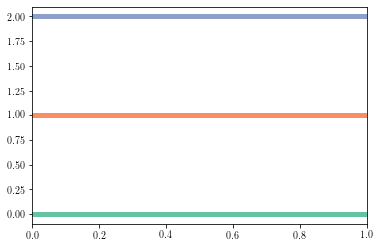

In [25]:
for i,j in enumerate(c):
    plt.axhline(i, c=j, lw=5)

# Process level variance (rMAD)

In [26]:
%%time
line_plots(f_L,h_L,g_L, f_name='Var-Var', h_name='Var-Fix', g_name='Fix-Var', masklist=masklist, mask_names=mask_names_it, col_names=col_names, c=c, weights=None, fu_multiplier=None, save_fig=True)



Global Warming Potential 100
Mask: All
Mask: All agg. reg.
Mask: {\it Global}
Mask: {\it Rest of World}
Mask: {\it Other agg. reg.}
Mask: Single Countries
Mask: CPC section 0
Mask: CPC section 1
Mask: CPC section 2
Mask: CPC section 3
Mask: CPC section 4


Land use
Mask: All
Mask: All agg. reg.
Mask: {\it Global}
Mask: {\it Rest of World}
Mask: {\it Other agg. reg.}
Mask: Single Countries
Mask: CPC section 0
Mask: CPC section 1
Mask: CPC section 2
Mask: CPC section 3
Mask: CPC section 4
/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/plots/rMAD_2impacts.jpg


CPU times: user 30 s, sys: 11.5 s, total: 41.5 s
Wall time: 45.5 s


## Distributions of variance (rMAD) weighted by prdocution volume. Weighted quantiles (C=1 consistent with numpy percentile)


 Global Warming Potential 100
weights given
weights given
weights given
Mask: All
Fix-Var: [0.01153022 0.02155219 0.0389086  0.49754822 0.5631486 ], 0.16633056410983324
Var-Var: [0.38669894 0.6430285  0.72037225 0.86919976 0.89285243], 0.7186157982032279
Var-Fix: [0.09995484 0.11357829 0.13385518 0.23803866 0.23820111], 0.16144005859929675
weights given
weights given
weights given
Mask: All agg. reg.
Fix-Var: [0.01162083 0.02043819 0.03944342 0.49760009 0.56277466], 0.167395408664246
Var-Var: [0.51813404 0.64303825 0.72086989 0.86955892 0.8928532 ], 0.7245037119023703
Var-Fix: [0.10884179 0.11361069 0.13385535 0.23803996 0.23819783], 0.16227185673330558
weights given
weights given
weights given
Mask: Global
Fix-Var: [0.03486454 0.09159203 0.12460687 0.24396451 0.38591366], 0.15074558770867696
Var-Var: [0.23174938 0.29344219 0.46990367 0.73958521 0.96332107], 0.49612234673696953
Var-Fix: [0.14148103 0.25935962 0.28850478 0.44991085 0.54979509], 0.34538423703365817
weights given
weights

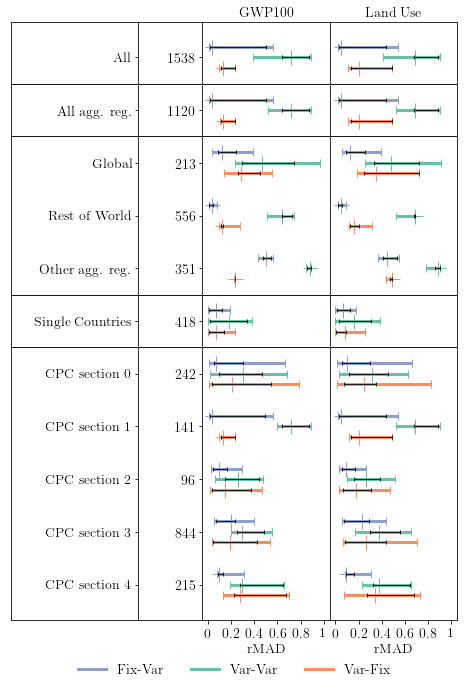

In [105]:
line_plots(f_L,h_L,g_L, f_name='Var-Var', h_name='Var-Fix', g_name='Fix-Var', masklist=masklist, mask_names=mask_names, col_names=col_names, c=c, weights=hdb.PRO['productionVolume'].to_numpy(), fu_multiplier=None, save_fig=False)

# Now consider relative increase with uncertainty compared to PLCA only

- Make table

In [114]:
def Make_process_level_table(results_array, lca_results, masks, mask_names, footprint_name, sim_names, col_units=None, bins=None):
    
    col_names = r'Subset & $N_\mathrm{proc}$ & Simlation run & $\mathrm{\overline{Increase}}$ & $\mathrm{\widetilde{Increase}}$ & FI uncertainty & Relative uncertainty \\'
    col_units = r' & & {\small Geography-Price} & {\small \%} & {\small \%} & {\small \%} & {\small \%} \\'

    file_dir = '/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/documents/paper2/61bc2f9c494d37b5d3f0481a/Tables/'
    file_name = 'Results_Overview_Process_Level_consumption_{}_VF-mean-price_all_masks.tex'.format(footprint_name.replace(' ',''))

    with open(os.path.join(file_dir, file_name), 'w') as fh:
        fh.write(r'\begin{tabular}{ccccccc}')
        fh.write(r'\toprule'+'\n')
        fh.write(r'\hiderowcolors'+'\n')
        fh.write(col_names+'\n')    
        fh.write(col_units+'\midrule\midrule'+'\showrowcolors'+'\n')
        
        Total_Impact = results_array+lca_results
        
        for j,(mask,mask_name) in enumerate(zip(masks, mask_names)):
            
            for i in range(len(results_array)):
                if i==1:
                    Mask_name = mask_name
                    mask_len = sum(mask)
                else:
                    Mask_name = ''
                    mask_len = ''
                percentiles_total_fp = np.percentile(Total_Impact[i][:,mask], [2.5,50,97.5], axis=0)
                
                percentiles_hybrid_part = np.percentile(results_array[i][:,mask], [2.5,50,97.5], axis=0)
                
                process_level_median_increase = np.nanmedian(percentiles_hybrid_part[1,:]/lca_results[mask])*100  # median median increase
                process_level_mean_increase = np.nanmedian(np.nanmean(results_array[i][:,mask], axis=0)/lca_results[mask])*100  # median mean increase
                
                total_lower_median = np.nanmedian((percentiles_total_fp[0,:]-percentiles_total_fp[1,:])/percentiles_total_fp[1,:]*100)
                total_upper_median = np.nanmedian((percentiles_total_fp[2,:]-percentiles_total_fp[1,:])/percentiles_total_fp[1,:]*100)
        
                IO_lower_median = np.nanmedian((percentiles_hybrid_part[0,:]-percentiles_hybrid_part[1,:])/percentiles_hybrid_part[1,:]*100)
                IO_upper_median = np.nanmedian((percentiles_hybrid_part[2,:]-percentiles_hybrid_part[1,:])/percentiles_hybrid_part[1,:]*100)
       
                
                table_string = r'{0} & ${1}$ & $\mathrm{{{2}}}$ & ${3:.1f}$  & ${4:.1f}$ & $({5:.1f},+{6:.1f})$ & $({7:.0f},+{8:.0f})$ \\'.format(
                        Mask_name, mask_len, sim_names[i], process_level_mean_increase, process_level_median_increase, 
                        total_lower_median, total_upper_median, IO_lower_median, IO_upper_median)
                fh.write(table_string+'\n')
                print(table_string)
            fh.write('\midrule'+'\n')
            print('\n')
        fh.write(r'\bottomrule')
        fh.write(r'\end{tabular}')          
   


In [12]:
def Make_dictionary(d, results_array, lca_results, masks, mask_names, footprint_name, sim_names):
    
    d['mask_name'] = []
    d['mask_len'] = []
    d['simulation_run'] = []
    d['increase_{}'.format(footprint_name)] = []
    d['uncertainty_low_{}'.format(footprint_name)] = []
    d['uncertainty_high_{}'.format(footprint_name)] = []
    
    
    Total_Impact = results_array+lca_results
        
    for j,(mask,mask_name) in enumerate(zip(masks, mask_names)):
            
            for i in range(len(results_array)):
                d['mask_name'].append(mask_name)
                d['mask_len'].append(sum(mask))
                
                percentiles_total_fp = np.percentile(Total_Impact[i][:,mask], [2.5,50,97.5], axis=0)
                percentiles_hybrid_part = np.percentile(results_array[i][:,mask], [2.5,50,97.5], axis=0)                
                process_level_median_increase = np.nanmedian(percentiles_hybrid_part[1,:]/lca_results[mask])*100  # median median increase
                
                total_lower_median = np.nanmedian((percentiles_total_fp[0,:]-percentiles_total_fp[1,:])/percentiles_total_fp[1,:]*100)
                total_upper_median = np.nanmedian((percentiles_total_fp[2,:]-percentiles_total_fp[1,:])/percentiles_total_fp[1,:]*100)
        
                d['simulation_run'].append(sim_names[i])
                d['increase_{}'.format(footprint_name)].append(process_level_median_increase)
                d['uncertainty_low_{}'.format(footprint_name)].append(total_lower_median)
                d['uncertainty_high_{}'.format(footprint_name)].append(total_upper_median)
    return d


In [11]:
lca_results = hdb.lca_impacts.copy()

In [109]:
del hdb

In [13]:
try:
    del process_FI_results
except:
    pass
process_FI_results = [f_L['io_impacts/Global Warming Potential 100'][()], h_L['io_impacts/Global Warming Potential 100'][()], g_L['io_impacts/Global Warming Potential 100'][()]]
names = ['Var-Var', 'Var-Fix', 'Fix-Var']

In [18]:
# checking the difference in GWP impacts LCA results
np.nanmean(lca_results[410,:]/lca_results[425,:])

1.0340643614255043

In [19]:
np.nanstd(lca_results[410,:]/lca_results[425,:])

0.06380928464611811

In [15]:
hdb.impact_names_io

array(['CO2 - GWP100', 'CH4 - GWP100', 'N2O - GWP100', 'SF6 - GWP100',
       'Global Warming Potential 100', 'Land use - crops',
       'Land use - pasture', 'Land use - forest', 'Land use',
       'Total Emission relevant energy use',
       'Total Energy inputs from nature', 'Total Energy supply',
       'Total Energy Use', 'Domestic extraction  - primary crops',
       'Domestic extraction  - crops residues',
       'Domestic extraction  - fodder crops',
       'Domestic extraction - grazing', 'Domestic extraction - wood',
       'Domestic extraction - aquatic animals',
       'Domestic extraction - metal ores',
       'Domestic extraction - nonmetallic minerals',
       'Domestic extraction - fossil fuels',
       'Domestic extraction used Total', 'Domestic extraction unused',
       'Material extraction Total - used and unused',
       'Water Consumption Green - Agriculture',
       'Water Consumption Blue - Agriculture',
       'Water Consumption Blue - Livestock',
       'Water

In [111]:
dictionary = {}

In [115]:
Make_process_level_table(process_FI_results, lca_results[425,:], masklist, mask_names, 'GWP 100', sim_names=names)
dictionary = Make_dictionary(dictionary, process_FI_results, lca_results[425,:], masklist, mask_names, 'GWP 100', sim_names=names)

 & $$ & $\mathrm{Var-Var}$ & $9.8$  & $6.5$ & $(-2.8,+18.2)$ & $(-50,+286)$ \\
All & $1538$ & $\mathrm{Var-Fix}$ & $6.7$  & $5.9$ & $(-1.3,+3.3)$ & $(-29,+72)$ \\
 & $$ & $\mathrm{Fix-Var}$ & $6.7$  & $5.4$ & $(-1.7,+7.4)$ & $(-36,+152)$ \\


 & $$ & $\mathrm{Var-Var}$ & $9.8$  & $6.1$ & $(-3.0,+22.1)$ & $(-54,+352)$ \\
All agg. reg. & $1120$ & $\mathrm{Var-Fix}$ & $6.2$  & $5.2$ & $(-1.7,+4.8)$ & $(-34,+94)$ \\
 & $$ & $\mathrm{Fix-Var}$ & $6.2$  & $5.0$ & $(-1.8,+7.8)$ & $(-39,+176)$ \\


 & $$ & $\mathrm{Var-Var}$ & $9.6$  & $6.4$ & $(-3.0,+21.0)$ & $(-52,+375)$ \\
Global & $213$ & $\mathrm{Var-Fix}$ & $6.1$  & $5.0$ & $(-1.9,+4.1)$ & $(-41,+86)$ \\
 & $$ & $\mathrm{Fix-Var}$ & $6.1$  & $4.7$ & $(-1.8,+9.1)$ & $(-39,+190)$ \\


 & $$ & $\mathrm{Var-Var}$ & $8.8$  & $5.4$ & $(-2.6,+20.3)$ & $(-52,+358)$ \\
Rest of World & $556$ & $\mathrm{Var-Fix}$ & $5.4$  & $4.7$ & $(-1.6,+4.7)$ & $(-38,+110)$ \\
 & $$ & $\mathrm{Fix-Var}$ & $5.3$  & $4.5$ & $(-1.4,+5.8)$ & $(-35,+153)$ \\


 & $$ 

In [116]:
try:
    del process_FI_results
except:
    pass
process_FI_results = [f_L['io_impacts/Land use'][()], h_L['io_impacts/Land use'][()], g_L['io_impacts/Land use'][()]]
names = ['Var-Var', 'Var-Fix', 'Fix-Var']

In [117]:
Make_process_level_table(process_FI_results, lca_results[[711,737],:].sum(axis=0)/1e6, masklist, mask_names, 'Land Use', sim_names=names)
dictionary = Make_dictionary(dictionary, process_FI_results, lca_results[[711,737],:].sum(axis=0)/1e6, masklist, mask_names, 'Land Use', sim_names=names)

 & $$ & $\mathrm{Var-Var}$ & $144.1$  & $90.3$ & $(-22.8,+142.7)$ & $(-54,+364)$ \\
All & $1538$ & $\mathrm{Var-Fix}$ & $103.6$  & $83.8$ & $(-12.5,+36.3)$ & $(-35,+106)$ \\
 & $$ & $\mathrm{Fix-Var}$ & $103.6$  & $80.4$ & $(-14.0,+58.4)$ & $(-37,+156)$ \\


 & $$ & $\mathrm{Var-Var}$ & $181.1$  & $112.1$ & $(-28.6,+187.6)$ & $(-57,+434)$ \\
All agg. reg. & $1120$ & $\mathrm{Var-Fix}$ & $121.2$  & $96.8$ & $(-16.8,+55.0)$ & $(-41,+139)$ \\
 & $$ & $\mathrm{Fix-Var}$ & $121.6$  & $95.8$ & $(-17.0,+74.3)$ & $(-39,+173)$ \\


 & $$ & $\mathrm{Var-Var}$ & $180.0$  & $111.9$ & $(-28.5,+169.1)$ & $(-56,+497)$ \\
Global & $213$ & $\mathrm{Var-Fix}$ & $120.3$  & $105.9$ & $(-20.4,+57.4)$ & $(-44,+138)$ \\
 & $$ & $\mathrm{Fix-Var}$ & $121.3$  & $91.3$ & $(-16.8,+84.2)$ & $(-40,+194)$ \\


 & $$ & $\mathrm{Var-Var}$ & $147.6$  & $100.7$ & $(-26.4,+161.6)$ & $(-58,+429)$ \\
Rest of World & $556$ & $\mathrm{Var-Fix}$ & $110.2$  & $84.8$ & $(-16.7,+55.7)$ & $(-45,+186)$ \\
 & $$ & $\mathrm{Fix-Var

In [25]:
try:
    del process_FI_results
except:
    pass
process_FI_results = [f_L['io_impacts/Water Consumption Blue - Total'][()], h_L['io_impacts/Water Consumption Blue - Total'][()], g_L['io_impacts/Water Consumption Blue - Total'][()]]
names = ['Var-Var', 'Var-Fix', 'Fix-Var']

In [33]:
# Check if 813 water depletion  (recipe (H)) is correct
Make_process_level_table(process_FI_results, hdb.lca_impacts[813,:]/1e6, masklist, mask_names, 'Water consumption blue', sim_names=names)

 & $$ & $\mathrm{Var-Var}$ & $2626.9$  & $1738.4$ & $(-47.7,+306.0)$ & $(-54.2,+363.8)$ \\
All & $1538$ & $\mathrm{Var-Fix}$ & $1606.8$  & $1268.9$ & $(-27.8,+85.4)$ & $(-34.4,+107.2)$ \\
 & $$ & $\mathrm{Fix-Var}$ & $1891.8$  & $1517.1$ & $(-30.6,+127.2)$ & $(-36.6,+156.0)$ \\


 & $$ & $\mathrm{Var-Var}$ & $3078.2$  & $1940.2$ & $(-51.6,+372.8)$ & $(-57.1,+433.6)$ \\
All agg. reg. & $1120$ & $\mathrm{Var-Fix}$ & $1919.1$  & $1449.8$ & $(-34.3,+115.0)$ & $(-42.0,+143.6)$ \\
 & $$ & $\mathrm{Fix-Var}$ & $2157.1$  & $1718.5$ & $(-34.1,+147.6)$ & $(-39.1,+173.1)$ \\


 & $$ & $\mathrm{Var-Var}$ & $2608.4$  & $1512.1$ & $(-50.0,+360.7)$ & $(-55.6,+496.6)$ \\
Global & $213$ & $\mathrm{Var-Fix}$ & $1610.9$  & $1377.5$ & $(-44.7,+126.0)$ & $(-48.1,+155.8)$ \\
 & $$ & $\mathrm{Fix-Var}$ & $1817.1$  & $1358.5$ & $(-34.7,+159.4)$ & $(-40.2,+193.7)$ \\


 & $$ & $\mathrm{Var-Var}$ & $2495.5$  & $1745.7$ & $(-50.9,+356.1)$ & $(-57.7,+428.6)$ \\
Rest of World & $556$ & $\mathrm{Var-Fix}$ & $1645.3

In [118]:
df = pd.DataFrame.from_dict(dictionary)
df

,mask_name,mask_len,simulation_run,increase_GWP 100,uncertainty_low_GWP 100,uncertainty_high_GWP 100,increase_Land Use,uncertainty_low_Land Use,uncertainty_high_Land Use
0,All,1538,Var-Var,6.472186,-2.790207,18.221908,90.267468,-22.784796,142.720297
1,All,1538,Var-Fix,5.883766,-1.279625,3.288397,83.817073,-12.505135,36.276762
2,All,1538,Fix-Var,5.406119,-1.665319,7.418530,80.381760,-13.970374,58.443683
3,All agg. reg.,1120,Var-Var,6.131789,-3.043197,22.087349,112.147927,-28.600112,187.648160
4,All agg. reg.,1120,Var-Fix,5.237800,-1.717129,4.840037,96.833935,-16.791465,54.977170
5,All agg. reg.,1120,Fix-Var,4.955538,-1.762338,7.774885,95.837358,-16.957244,74.308462
6,Global,213,Var-Var,6.386810,-3.043250,20.976973,111.906665,-28.496998,169.068862
7,Global,213,Var-Fix,4.975552,-1.946062,4.097198,105.872490,-20.432155,57.367536
8,Global,213,Fix-Var,4.711273,-1.800748,9.137033,91.295585,-16.752655,84.226841
9,Rest of World,556,Var-Var,5.382772,-2.638216,20.271843,100.656421,-26.351284,161.595055


In [204]:
df.to_feather('/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/Databases/process_FI_increase_df_Var-Fix-with-mean-baci-price.ftr')

In [67]:
df =  pd.read_feather('/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/Databases/process_FI_increase_df_Var-Fix-with-mean-baci-price.ftr')

In [205]:
df.to_excel('/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/plots/plot_data/FI_increase_subsets_GWP100_LandUse.xlsx')

In [124]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
# Set notebook mode to work in offline
pyo.init_notebook_mode(connected=True)

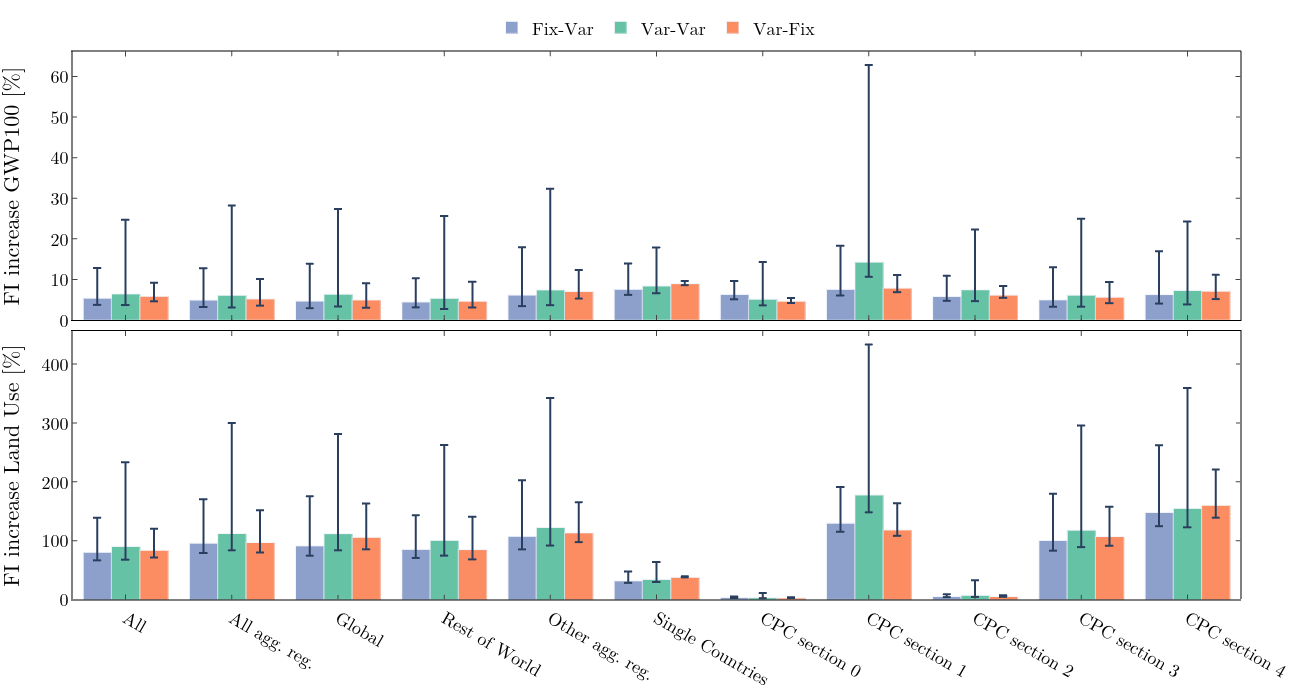

In [153]:
fig = make_subplots(rows=2, shared_xaxes=True, vertical_spacing=0.02)

fix_var_gwp = go.Bar(name='Fix-Var',
    x=df.set_index('simulation_run').loc['Fix-Var']['mask_name'].values,
    y=df.set_index('simulation_run').loc['Fix-Var']['increase_GWP 100'].values,
    offsetgroup=-1,
    error_y=dict(
            type='data',
            symmetric=False,
            array=df.set_index('simulation_run').loc['Fix-Var']['uncertainty_high_GWP 100'].values,
            arrayminus=-df.set_index('simulation_run').loc['Fix-Var']['uncertainty_low_GWP 100'].values)
    )
var_var_gwp = go.Bar(name='Var-Var',
    x=df.set_index('simulation_run').loc['Var-Var']['mask_name'].values,
    y=df.set_index('simulation_run').loc['Var-Var']['increase_GWP 100'].values,
    offsetgroup=0,
    error_y=dict(
            type='data',
            symmetric=False,
            array=df.set_index('simulation_run').loc['Var-Var']['uncertainty_high_GWP 100'].values,
            arrayminus=-df.set_index('simulation_run').loc['Var-Var']['uncertainty_low_GWP 100'].values)
    )
var_fix_gwp = go.Bar(name='Var-Fix',
    x=df.set_index('simulation_run').loc['Var-Fix']['mask_name'].values,
    y=df.set_index('simulation_run').loc['Var-Fix']['increase_GWP 100'].values,
    offsetgroup=1,
    error_y=dict(
            type='data',
            symmetric=False,
            array=df.set_index('simulation_run').loc['Var-Fix']['uncertainty_high_GWP 100'].values,
            arrayminus=-df.set_index('simulation_run').loc['Var-Fix']['uncertainty_low_GWP 100'].values)
    )
fig.add_trace(fix_var_gwp, row=1, col=1)   
fig.add_trace(var_var_gwp, row=1, col=1)   
fig.add_trace(var_fix_gwp, row=1, col=1)
fig.update_traces(showlegend=False)

# Now land use footprint in second subplot
fix_var_lu = go.Bar(name='Fix-Var',
    x=df.set_index('simulation_run').loc['Fix-Var']['mask_name'].values,
    y=df.set_index('simulation_run').loc['Fix-Var']['increase_Land Use'].values,
    offsetgroup=-1,
    error_y=dict(
            type='data',
            symmetric=False,
            array=df.set_index('simulation_run').loc['Fix-Var']['uncertainty_high_Land Use'].values,
            arrayminus=-df.set_index('simulation_run').loc['Fix-Var']['uncertainty_low_Land Use'].values)
    )
var_var_lu = go.Bar(name='Var-Var',
    x=df.set_index('simulation_run').loc['Var-Var']['mask_name'].values,
    y=df.set_index('simulation_run').loc['Var-Var']['increase_Land Use'].values,
    offsetgroup=0,
    error_y=dict(
            type='data',
            symmetric=False,
            array=df.set_index('simulation_run').loc['Var-Var']['uncertainty_high_Land Use'].values,
            arrayminus=-df.set_index('simulation_run').loc['Var-Var']['uncertainty_low_Land Use'].values)
    )
var_fix_lu = go.Bar(name='Var-Fix',
    x=df.set_index('simulation_run').loc['Var-Fix']['mask_name'].values,
    y=df.set_index('simulation_run').loc['Var-Fix']['increase_Land Use'].values,
    offsetgroup=1,
    error_y=dict(
            type='data',
            symmetric=False,
            array=df.set_index('simulation_run').loc['Var-Fix']['uncertainty_high_Land Use'].values,
            arrayminus=-df.set_index('simulation_run').loc['Var-Fix']['uncertainty_low_Land Use'].values)
    )

fig.add_trace(fix_var_lu, row=2, col=1)   
fig.add_trace(var_var_lu, row=2, col=1)   
fig.add_trace(var_fix_lu, row=2, col=1)   


fig.update_layout(go.Layout(
    autosize=False,
    font=dict(
        family='Latin Modern Math',
        color='black',
        size=18,
    ),
    colorway=[c[2],c[0],c[1]],
    width=700,
    height=700,
    margin=dict(l=10,r=10,t=10,b=10),
    paper_bgcolor='rgba(255,255,255,1)',
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis=dict(
        showline=True,
        linecolor='black',
        ticks='inside',
        exponentformat='e',
        mirror='ticks',
    ),
    yaxis=dict(
        title=r'FI increase GWP100 [%]',
        showline=True,
        linecolor='black',
        ticks='inside',
        exponentformat='e',
        mirror='ticks',
    ),
    xaxis2=dict(
        showline=True,
        linecolor='black',
        ticks='inside',
        exponentformat='e',
        mirror='ticks',
    ),
    yaxis2=dict(
        title=r'FI increase Land Use [%]',
        showline=True,
        linecolor='black',
        ticks='inside',
        exponentformat='e',
        mirror='ticks',
    ),
    legend=dict(
        xanchor="center",
        yanchor="bottom",
        x=0.5,
        y=1.01,
        orientation="h"
    )
    )
    )
fig.write_image('/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/plots/FI_increase_GWP100_LU_process_groups.pdf')
fig.show()


## Try to understand what goes on in cpc section 1

In [17]:
# first make the masks easily accisble
mask_dictionary = {key:mask for key,mask in zip(mask_names,masklist)}

In [18]:
mask_dictionary['CPC section 1']

array([False, False, False, ..., False, False, False])

In [ ]:

Total_Impact = results_array+lca_results

for j,(mask,mask_name) in enumerate(zip(masks, mask_names)):

        for i in range(len(results_array)):
            d['mask_name'].append(mask_name)
            d['mask_len'].append(sum(mask))

            percentiles_total_fp = np.percentile(Total_Impact[i][:,mask], [2.5,50,97.5], axis=0)
            percentiles_hybrid_part = np.percentile(results_array[i][:,mask], [2.5,50,97.5], axis=0)                
            process_level_median_increase = np.nanmedian(percentiles_hybrid_part[1,:]/lca_results[mask])*100  # median median increase

            total_lower_median = np.nanmedian((percentiles_total_fp[0,:]-percentiles_total_fp[1,:])/percentiles_total_fp[1,:]*100)
            total_upper_median = np.nanmedian((percentiles_total_fp[2,:]-percentiles_total_fp[1,:])/percentiles_total_fp[1,:]*100)

            d['simulation_run'].append(sim_names[i])
            d['increase_{}'.format(footprint_name)].append(process_level_median_increase)
            d['uncertainty_low_{}'.format(footprint_name)].append(total_lower_median)
            d['uncertainty_high_{}'.format(footprint_name)].append(total_upper_median)


In [21]:
hdb.PRO.loc[mask_dictionary['CPC section 1']]

,activityId,productId,activityName,ISIC,price,priceUnit,EcoSpoldCategory,geography,technologyLevel,macroEconomicScenario,...,unitName,cpc,dry mass [kg],wet mass [kg],activityNameId,activityType,startDate,endDate,io_geography,ProductTypeName
3c10ba7a-c90b-45d6-932b-4b5b54b09d4e_3cffc0cb-7f0f-41f1-b467-1a7f40fc45ec,3c10ba7a-c90b-45d6-932b-4b5b54b09d4e,3cffc0cb-7f0f-41f1-b467-1a7f40fc45ec,hard coal mine operation,0510:Mining of hard coal,0.041760,EUR2005,hard coal/production,IN,Current,Business-as-Usual,...,kg,11010: Hard coal,1,1.002,8607d1f8-8d1b-4c74-97a2-7b0be85229e8,0,2006-01-01,2020-01-01,IN,Anthracite
237ae40c-de7b-42f2-abcc-f45b0a90e976_0d3eda5a-4601-4573-9549-0701c459ab88,237ae40c-de7b-42f2-abcc-f45b0a90e976,0d3eda5a-4601-4573-9549-0701c459ab88,hard coal mine operation and hard coal prepara...,0510:Mining of hard coal,0.041760,EUR2005,hard coal/production,"Europe, without Russia and Turkey",Current,Business-as-Usual,...,kg,11010: Hard coal,0.94,1,37a56a98-090b-48e1-a3f6-fb7153eb3702,0,1990-01-01,2018-12-31,RER,Anthracite
e23b0dd7-7087-41d7-a873-04a15f08f544_0d3eda5a-4601-4573-9549-0701c459ab88,e23b0dd7-7087-41d7-a873-04a15f08f544,0d3eda5a-4601-4573-9549-0701c459ab88,hard coal mine operation and hard coal prepara...,0510:Mining of hard coal,0.041760,EUR2005,hard coal/production,RU,Current,Business-as-Usual,...,kg,11010: Hard coal,0.94,1,37a56a98-090b-48e1-a3f6-fb7153eb3702,0,1990-01-01,2018-12-31,RU,Anthracite
dcfb6365-7210-49d0-a73c-d0e636faf984_0d3eda5a-4601-4573-9549-0701c459ab88,dcfb6365-7210-49d0-a73c-d0e636faf984,0d3eda5a-4601-4573-9549-0701c459ab88,hard coal mine operation and hard coal prepara...,0510:Mining of hard coal,0.041760,EUR2005,hard coal/production,RLA,Current,Business-as-Usual,...,kg,11010: Hard coal,0.94,1,37a56a98-090b-48e1-a3f6-fb7153eb3702,0,1990-01-01,2018-12-31,RLA,Anthracite
96e03844-f6b6-417f-866c-1554f2b256f9_0d3eda5a-4601-4573-9549-0701c459ab88,96e03844-f6b6-417f-866c-1554f2b256f9,0d3eda5a-4601-4573-9549-0701c459ab88,hard coal mine operation and hard coal prepara...,0510:Mining of hard coal,0.041760,EUR2005,hard coal/production,RoW,Current,Business-as-Usual,...,kg,11010: Hard coal,0.94,1,37a56a98-090b-48e1-a3f6-fb7153eb3702,0,1999-01-01,2018-12-31,RoW(56),Anthracite
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
e9e419f8-2cf0-46c8-b6ab-bc75c398a992_c5adb1fb-872e-4446-a3bb-c4b61aa4bd45,e9e419f8-2cf0-46c8-b6ab-bc75c398a992,c5adb1fb-872e-4446-a3bb-c4b61aa4bd45,"tap water production, underground water withou...","3600:Water collection, treatment and supply",0.000461,EUR2005,water supply/production,CH,Current,Business-as-Usual,...,kg,18000: Natural water,0.00033747615607878,1,f4dd0b2a-fab9-49b8-a080-b2621ac4e29c,0,2012-01-01,2018-12-31,CH,"Collected and purified water, distribution ser..."
d5bf8692-a5c3-4d1c-a859-cd691ac938b5_c5adb1fb-872e-4446-a3bb-c4b61aa4bd45,d5bf8692-a5c3-4d1c-a859-cd691ac938b5,c5adb1fb-872e-4446-a3bb-c4b61aa4bd45,"tap water production, underground water withou...","3600:Water collection, treatment and supply",0.000461,EUR2005,water supply/production,CA-QC,Current,Business-as-Usual,...,kg,18000: Natural water,0.00033747615607878,1,f4dd0b2a-fab9-49b8-a080-b2621ac4e29c,0,2012-01-01,2018-12-31,CA,"Collected and purified water, distribution ser..."
b5e85f48-39c1-4b88-a9df-dda7d2fb5c9b_360e2eb0-f81c-4e4b-ba6b-c7a690f31275,b5e85f48-39c1-4b88-a9df-dda7d2fb5c9b,360e2eb0-f81c-4e4b-ba6b-c7a690f31275,"water production, deionised, from tap water, a...","3600:Water collection, treatment and supply",0.000631,EUR2005,NaN,Europe without Switzerland,Current,Business-as-Usual,...,kg,18000: Natural water,0,1,7c8694dc-8e4f-4831-b213-c89b483e84b9,0,1992-01-01,2018-12-31,Europe without Switzerland,"Collected and purified water, distribution ser..."
a8068dc9-06ea-48a6-8510-9f0fdfd0706e_360e2eb0-f81c-4e4b-ba6b-c7a690f31275,a8068dc9-06ea-48a6-8510-9f0fdfd0706e,360e2eb0-f81c-4e4b-ba6b-c7a690f31275,"water production, deionised, from tap water, a...","3600:Water co

In [26]:
# check if there is a dicrepancy in the mean/median price and price variance between aggregated and regionalised case

In [27]:
proc = 'd1b7438f-f699-457b-9cb9-9b1e37ec9077_360e2eb0-f81c-4e4b-ba6b-c7a690f31275'

In [47]:
data = hdb.price_data_df.loc[proc]
print('{:.2g} {:.2g} {:.2g}'.format(data.mean(), data.median(), data.std()))

0.0013 0.0005 0.023


In [35]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

In [ ]:
data = hdb.price_dict[proc]['pricesByCountry']
regions = []
means = []
medians = []
stds = []
mins = []
maxs = []
n_flows = []
for region,datas in data.items():
    regions.append(region)
    means.append(datas['price_baci_mean'])
    medians.append(datas['price_percentiles'][2])
    stds.append(datas['price_baci_std'])
    mins.append(datas['price_baci_min'])
    maxs.append(datas['price_baci_max'])
    n_flows.append(datas['nr_baci_flows'])

plt.axhline(0, 0,1, c='k', lw=0.2)
for i,(r,m,mm,s,mi,ma,n) in enumerate(zip(regions, means, medians, stds, mins, maxs, n_flows)):
    plt.errorbar(i+1,m, yerr=s)
    print('{}: {:.3g} {:.2g} {}'.format(r,m,s, n))
plt.xticks(ticks=np.arange(len(regions))+1, labels=regions)


In [56]:
regions

['WM',
 'WA',
 'WL',
 'WF',
 'AU',
 'BR',
 'CA',
 'CN',
 'CY',
 'ID',
 'IN',
 'JP',
 'KR',
 'MX',
 'RU',
 'TR',
 'TW',
 'US',
 'ZA']

In [49]:
hdb.price_dict[proc]


{'activityName': 'water production, deionised, from tap water, at user',
 'geography': 'RoW',
 'productName': 'water, deionised, from tap water, at user',
 'cpc': '18000: Natural water',
 'unitName': 'kg',
 'pricesByCountry': {'WM': {'prices_euro': array([8.37899543e-01, 1.42408639e-02, 1.43713307e+00, 6.19940847e+01,
          4.54026567e+00, 1.12942676e-01, 3.50751342e-01, 3.50757665e-01,
          3.50757665e-01, 4.51995319e-01, 1.07639089e+00, 3.50757665e-01,
          1.02110155e-01, 1.10204651e-01, 9.49996541e-02, 1.34073836e+01,
          1.60111187e-01, 1.07952586e-01, 1.58982187e-01, 5.93088418e-01,
          7.92482735e+00, 5.31631500e-01, 4.60227422e-01, 2.06648893e-01,
          4.77469579e-01, 8.58825345e-01, 1.41608636e+00, 2.41791879e-01,
          7.72201038e-01, 6.27018095e-02, 1.60252483e-01, 6.46558290e-01,
          6.17556464e-01, 2.33085921e+00, 3.91098295e-01, 1.92919992e-01,
          2.43820687e-01, 3.75794658e-01, 1.55666252e+00, 9.39765893e-01,
          3.76

# Now see if there is any correlation to be seen between total impact (for gloabl produciton volume) and the variance (rMAD)

In [36]:
f_gwp100_prodvol = f['io_impacts/Global Warming Potential 100'][()]*hdb.PRO['productionVolume'].to_numpy()
h_gwp100_prodvol = h['io_impacts/Global Warming Potential 100'][()]*hdb.PRO['productionVolume'].to_numpy()
g_gwp100_prodvol = g['io_impacts/Global Warming Potential 100'][()]*hdb.PRO['productionVolume'].to_numpy()

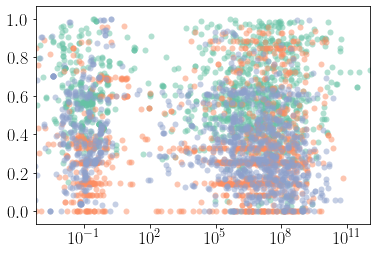

In [123]:
fig, ax = plt.subplots(1)
medians1 = np.abs(np.nanmedian(f_gwp100_prodvol[:,masklist[1]], axis=0))
rMAD1 = np.nan_to_num(scipy.stats.median_abs_deviation(f_gwp100_prodvol[:,masklist[1]], axis=0)/medians1)
ax.scatter(medians1, rMAD1, marker='o', linewidth=0, color=c[0], alpha=0.5)
ax.set_xscale('log')
ax.set_xlim((6e-4, np.max(medians1)))
medians2 = np.abs(np.nanmedian(h_gwp100_prodvol[:,masklist[1]], axis=0))
rMAD2 = np.nan_to_num(scipy.stats.median_abs_deviation(h_gwp100_prodvol[:,masklist[1]], axis=0)/medians2)
ax.scatter(medians2, rMAD2, marker='o', linewidth=0, color=c[1], alpha=0.5)
medians3 = np.abs(np.nanmedian(g_gwp100_prodvol[:,masklist[1]], axis=0))
rMAD3 = np.nan_to_num(scipy.stats.median_abs_deviation(g_gwp100_prodvol[:,masklist[1]], axis=0)/medians3)
ax.scatter(medians3, rMAD3, marker='o', linewidth=0, color=c[2], alpha=0.5)
#ax.set_yscale('log')
#ax.set_ylim((1e-3,1))

(0.00036832062600568403, 8621162202486116.0)

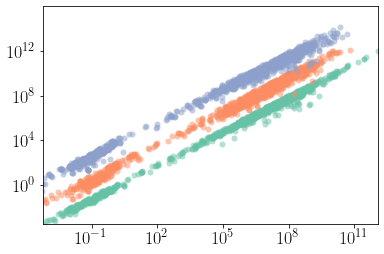

In [119]:
fig, ax = plt.subplots(1)
medians1 = np.abs(np.nanmedian(f_gwp100_prodvol[:,masklist[1]], axis=0))
MAD1 = scipy.stats.median_abs_deviation(f_gwp100_prodvol[:,masklist[1]], axis=0)
ax.scatter(medians1, MAD1, marker='o', linewidth=0, color=c[0], alpha=0.5)
ax.set_xscale('log')
ax.set_xlim((6e-4, np.max(medians1)))
medians2 = np.abs(np.nanmedian(h_gwp100_prodvol[:,masklist[1]], axis=0))
MAD2 = scipy.stats.median_abs_deviation(h_gwp100_prodvol[:,masklist[1]], axis=0)
ax.scatter(medians2, MAD2*1e2, marker='o', linewidth=0, color=c[1], alpha=0.5)
medians3 = np.abs(np.nanmedian(g_gwp100_prodvol[:,masklist[1]], axis=0))
MAD3 = scipy.stats.median_abs_deviation(g_gwp100_prodvol[:,masklist[1]], axis=0)
ax.scatter(medians3, MAD3*1e4, marker='o', linewidth=0, color=c[2], alpha=0.5)
ax.set_yscale('log')
ax.set_ylim((np.sort(MAD1)[17], np.max(MAD1)*1e4))

9 9


[[<matplotlib.axis.YTick at 0x7f661dcb9f28>,
 Text(0, 0.5, 'List item returned'),
 Text(0.5, 0, 'Percentile'),
 Text(0.5, 1.0, 'Interpolation methods for list: [1 2 3 4 5 6 7 8 9]')]

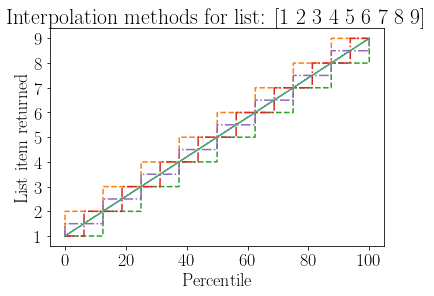

In [91]:
# a = np.array([1,2,2.5,4,10,11,12,101,101.5,102,102.5,103,103.1,103.4])
a = np.array([1,2,3,4,5,6,7,8,9])
p = np.linspace(0, 100, 6001)
weights = np.array([1,3,5,4,3,1,2,3,4])
weights = np.ones(len(a))
fig,ax = plt.subplots(1)
lines = [
            ('linear', None),
            ('higher', '--'),
            ('lower', '--'),
            ('nearest', '-.'),
            ('midpoint', '-.'),
        ]
for interpolation, style in lines:
            ax.plot(p, np.percentile(a, p, interpolation=interpolation),
                label=interpolation, linestyle=style)
        
print(len(a),len(weights))

ax.plot(p,weighted_percentile(a,weights,p/100, C=1), 'g,')
        
ax.set(
            title='Interpolation methods for list: ' + str(a),
            xlabel='Percentile',
            ylabel='List item returned',
            yticks=a)
# ax.legend()

## Comparison of price variabilty with regional vs aggregated price distributions

In [3]:
def line_plots_prices(price_dict, price_data_array, f_name, h_name, masklist, mask_names, col_names, c, save_fig=False):
    mask_lens = [sum(mask) for mask in masklist]
    tick_labels = [x+'  ' for (x,mask) in zip(mask_names, masklist)]
    
    lw1 = 0
    lw2 = 0
    elw1 = 3
    elw2 = 1.5
    cs1 = 4
    cs2 = 2
    offset=0.15
    ms_mean = 12
    ms_median = 15
    sns.set_color_codes()
    #c = ['#66c2a5','#fc8d62','#8da0cb']


    for j in ['dummylist because I am lazy...']:
        
        fig  = plt.figure(j, figsize=(6,8))
        supax = fig.add_subplot(111)
        ax = fig.add_subplot(153)
        ax2 = fig.add_subplot(143)
        ax3 = fig.add_subplot(122)
        ypositions = np.linspace(1,len(mask_names),len(mask_names))-1
        #ypositions = np.linspace(1,6,6)-1

        
        list_of_rmads1 = []
        list_of_rmads2 = []

        for i,(mask,mask_name) in enumerate(zip(masklist, mask_names)):
            
            uuids = hdb.PRO.loc[mask].index.to_numpy()
            
            
            # dataset1
            rMAD1 = np.nan_to_num(scipy.stats.median_abs_deviation(price_data_array[mask,:], axis=1)/
                                    np.abs(np.nanmedian(price_data_array[mask,:], axis=1)))
            # Line above: Take absolut value in case of negative final demand multipliers as we are interested in the variance, not the sign
            percentiles_rMAD1 = np.percentile(rMAD1, [2.5,16,50,84,97.5])
            mean1 = np.mean(rMAD1)
            list_of_rmads1.append(rMAD1)
            
            ax3.errorbar(mean1, ypositions[5-i]+offset,
                         xerr=np.array([[mean1-percentiles_rMAD1[0],
                                         percentiles_rMAD1[-1]-mean1]]).T, c='gray', fmt='+', markersize=ms_mean, lw=lw2, elinewidth=elw2, capsize=cs2, zorder=5)
            l1 = ax3.errorbar(percentiles_rMAD1[2], ypositions[5-i]+offset,
                         xerr=np.array([[percentiles_rMAD1[2]-percentiles_rMAD1[1],
                                         percentiles_rMAD1[-2]-percentiles_rMAD1[2]]]).T, c=c[0], fmt='+', markersize=ms_median, lw=lw1, elinewidth=elw1, capsize=cs1, zorder=10)
        
            #dataset2
            rMAD2 = []
            for uuid in uuids:
                proc_price_dict = price_dict[uuid]['pricesByCountry']
                for country in proc_price_dict.keys():
                    rMAD2.append(scipy.stats.median_abs_deviation(proc_price_dict[country]['price_sample'])/np.median(proc_price_dict[country]['price_sample']))
            
            
            #rMAD2 = np.nan_to_num(scipy.stats.median_abs_deviation(io_impacts2[mask,:], axis=1)/
            #                        np.abs(np.nanmedian(io_impacts2[mask,:], axis=1)))
            # Line above: Take absolut value in case of negative final demand multipliers as we are interested in the variance, not the sign            
            percentiles_rMAD2 = np.percentile(rMAD2, [2.5,16,50,84,97.5])
            mean2 = np.mean(rMAD2)
            list_of_rmads2.append(np.array(rMAD2))
            
            ax3.errorbar(mean2, ypositions[5-i]-offset,
                         xerr=np.array([[mean2-percentiles_rMAD2[0],
                                         percentiles_rMAD2[-1]-mean2]]).T, c='gray', fmt='+', markersize=ms_mean, ls='--', lw=lw2, elinewidth=elw2, capsize=cs2, zorder=5)
            l2 = ax3.errorbar(percentiles_rMAD2[2], ypositions[5-i]-offset,
                         xerr=np.array([[percentiles_rMAD2[2]-percentiles_rMAD2[1],
                                         percentiles_rMAD2[-2]-percentiles_rMAD2[2]]]).T, c=c[1], fmt='+', markersize=ms_median, ls='--', lw=lw1, elinewidth=elw1, capsize=cs1, zorder=10)
            
            
            print('Mask: {}'.format(mask_name))
            print('{}: {}, {}'.format(f_name, percentiles_rMAD1, mean1))
            print('{}: {}, {}'.format(h_name, percentiles_rMAD2, mean2))
        
        #lines = [l3,l1,l2]
        lines = [Line2D([0], [0], color=color, linewidth=3, linestyle='-') for color in [c[0],c[1]]]
        labels = [f_name, h_name]
        plt.legend(lines, labels, bbox_to_anchor=(-1.08, 0.99), loc='upper left', borderaxespad=0, frameon=False, prop={'size':12})

    
        ymax, ymin = ax3.get_ylim()

        ax.set_yticks(ypositions)
        ax.set_yticklabels(tick_labels, fontsize=14)
        ax.set_xticks([])
        
        ax.set_ylim((ymin-0.05,ymax+0.05))
        #ax.tick_params(axis=u'both', which=u'both',length=0)
        ax.set_title(r'Subset\, ', loc='left', horizontalalignment='right')

        supax.set_xlim((0,1))
        supax.set_ylim((ymin-0.05,ymax+0.05))
        #supax.axhline(y=12.5,c='k',lw=1)
        supax.axhline(y=4.5,c='k',lw=1)
        supax.axhline(y=1.5,c='k',lw=1)
        supax.axhline(y=0.5,c='k',lw=1)
    
        #ax.axhline(y=12.5,c='k',lw=1)
        ax.axhline(y=4.5,c='k',lw=1)
        ax.axhline(y=1.5,c='k',lw=1)
        ax.axhline(y=0.5,c='k',lw=1)
    
    
        #ax2.axhline(y=12.5,c='k',lw=1)
        ax2.axhline(y=4.5,c='k',lw=1)
        ax2.axhline(y=1.5,c='k',lw=1)
        ax2.axhline(y=0.5,c='k',lw=1)
    
        #ax3.axhline(y=12.5,c='k',lw=1)
        ax3.axhline(y=0.5,c='k',lw=1)
        ax3.axhline(y=3.5,c='k',lw=1)
        ax3.axhline(y=4.5,c='k',lw=1)
    
        #ax2.set_xlim(-0.1, 11)        
        ax2.set_yticks(ypositions)
        ax2.set_yticklabels(mask_lens, fontsize=14)
        ax2.set_xticks([])
        ax2.set_ylim((ymin-0.05,ymax+0.05))
        ax2.tick_params(axis=u'both', which=u'both',length=0)
        ax2.set_title(r'$N_\mathrm{act}$', loc='left', horizontalalignment='right')

        #ax3.set_yticks([])
        ax3.set_yticklabels([])
        #ax3.set_title(r'{}'.format(titles[j]))
        ax3.set_ylim((ymax+0.05,ymin-0.05))
        ax3.set_xlabel('rMAD')
        ax3.set_xticks([0,0.2,0.4,0.6,0.8])
        #ax.set_xticklabels(fontsize=14)
    
    

        supax.tick_params(axis='both', which='both', length=0)
        supax.set_xticks([])
        supax.set_yticks([])
        # supax.legend(loc='upper left', frameon=False)


        sns.despine(ax=ax, bottom=True, left=False, top=False)
        sns.despine(ax=ax2, bottom=True, left=True, top=False)
        # sns.despine(ax=ax3)
        #plt.tight_layout()
        if save_fig==True:
            fig_name = '/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/plots/rMAD_prices.png'
            print(fig_name)
            fig.savefig(fig_name)
        plt.show()
        return list_of_rmads1, list_of_rmads2
        

In [4]:
len(hdb.processes_with_baci_price)

1538

Mask: All
aggregated: [0.         0.03434436 0.2544129  0.54248166 0.79416815], 0.2864544038477617
regional: [0.         0.         0.13667461 0.50428183 0.81765534], 0.22229961122455358
Mask: All agg. reg.
aggregated: [0.         0.1335941  0.31690933 0.59925876 0.85872033], 0.35082130141045087
regional: [0.         0.         0.13818734 0.50663011 0.81822235], 0.22353677025456567
Mask: Global
aggregated: [0.03348466 0.23288691 0.40914048 0.61262173 0.99334905], 0.43337889289695325
regional: [0.         0.         0.20518219 0.60903758 0.88886399], 0.2771390421172579
Mask: Rest of World
aggregated: [0.         0.09768664 0.26529411 0.49762854 0.78493869], 0.3033721390255863
regional: [0.         0.         0.08789519 0.43453486 0.77417515], 0.1840807124879022
Mask: Other agg. reg.
aggregated: [0.04384466 0.18153567 0.36364739 0.61384405 0.70773651], 0.37588388630891156
regional: [0.         0.         0.1737203  0.50504208 0.79950058], 0.23593410966786796
Mask: Single Countries
aggreg

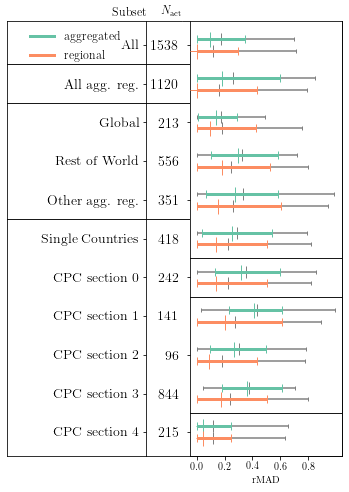

In [14]:
list_rmads_aggregated, list_rmads_regional = line_plots_prices(hdb.price_dict, hdb.price_data_array, 'aggregated', 'regional', masklist=masklist, mask_names=mask_names, col_names=col_names, c=c, save_fig=False)

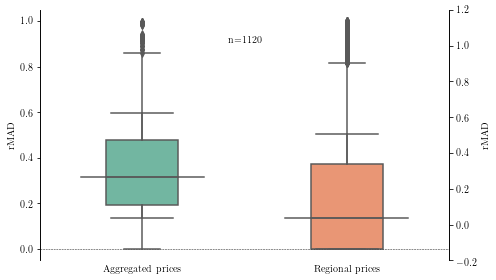

In [141]:
from matplotlib import ticker as mticker
fig = plt.figure(1, figsize=(7,4))
ax = fig.add_subplot(111)
dists = [list_rmads_aggregated[1], list_rmads_regional[1]] 
Labels = ['Aggregated prices', 'Regional prices']
#log_dists = [np.log10(dist.values) for dist in dists]

plt.axhline(y=0, color='k', ls='--', lw=0.5)

sns.boxplot(data=dists, showfliers=True, showbox=True, whis=[2.5,97.5], width=.35, linewidth=1.5)
sns.boxplot(data=dists, showfliers=False, showbox=False, whis=[16,84], width=.6, linewidth=1.5)
#sns.violinplot(data=dists, showmeans=False, showextrema=False,
#               showmedians=True, ax=ax, saturation=0.4,linewidth=1.5,
#               showfliers=True, inner='box')


#sns.boxplot(data=log_dists,ax=ax, saturation=0.4, color=None)

#ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
#ax.yaxis.set_ticks([np.log10(x) for p in range(-6,1) for x in np.linspace(10**p, 10**(p+1), 10)], minor=True)
#ax.set_ylim(-3,3)

#xticks
xticks = ax.get_xticks()
xtick_labels = Labels
ax.set_xticklabels(xtick_labels)
ax.tick_params(axis='x', which='both', length=0)

ax.set_ylabel(r'rMAD')
ax.text(0.5, 0.9, s='n={}'.format(len(dists[0])), 
            horizontalalignment='center', verticalalignment='top', 
            transform=ax.transAxes)

ax2 = ax.twinx()
ax2.set_yticks(ax.get_yticks())
#ax2.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ax2.set_ylabel(r'rMAD')
sns.despine(bottom=True, right=False)
fig.tight_layout()
fig.savefig('/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/plots/price_variation_comparison.png',
           bbox_inches='tight', pad_inches = 0.01)
plt.show()

(array([5.06898008, 1.35834351, 1.15272121, 1.00728898, 0.78214558,
        0.66176543, 0.5898627 , 0.41807698, 0.43434457, 0.25670252,
        0.15128856, 0.12265761]),
 array([0.        , 0.08330433, 0.16660866, 0.24991299, 0.33321733,
        0.41652166, 0.49982599, 0.58313032, 0.66643465, 0.74973898,
        0.83304331, 0.91634765, 0.99965198]),
 <a list of 12 Patch objects>)

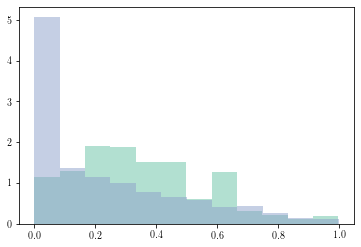

In [116]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(list_rmads_aggregated[1], color=c[0], alpha=0.5, density=True, bins=12)
ax.axvline(np.median())
ax.hist(list_rmads_regional[1], color=c[2], alpha=0.5, density=True, bins=12)


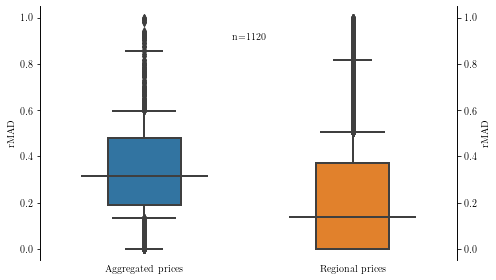

In [11]:
fig = plt.figure(1, figsize=(7,4))
ax = fig.add_subplot(111)
dists = [list_rmads_aggregated[1], list_rmads_regional[1]] 
Labels = ['Aggregated prices', 'Regional prices']

sns.boxplot(data=dists, showfliers=False, showbox=True, whis=[2.5,97.5], width=.35, linewidth=2, )
sns.boxplot(data=dists, showfliers=True, showbox=False, whis=[16,84], width=.6, linewidth=2)

xticks = ax.get_xticks()
xtick_labels = Labels
ax.set_xticklabels(xtick_labels)
ax.tick_params(axis='x', which='both', length=0)

ax.set_ylabel(r'rMAD')
ax.text(0.5, 0.9, s='n={}'.format(len(dists[0])), 
            horizontalalignment='center', verticalalignment='top', 
            transform=ax.transAxes)

ax2 = ax.twinx()
ax2.set_yticks(ax.get_yticks())
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel(r'rMAD')

sns.despine(bottom=True, right=False)

fig.tight_layout()
fig.savefig('/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/plots/price_variation_comparison.pdf',
           bbox_inches='tight', pad_inches=0.01)
plt.show()

In [134]:
sns.set_palette(c)

In [12]:
print(np.median(list_rmads_aggregated[1]))
print(np.median(list_rmads_regional[1]))

0.31690933071799704
0.13818733782202328


In [15]:
len(list_rmads_aggregated[1])

1120

In [14]:
len(list_rmads_regional[1])

36896

In [18]:
n_zeros = np.count_nonzero(list_rmads_regional[1]==0)
print(n_zeros)

In [54]:
uuids = hdb.PRO.loc[masklist[1]].index.to_numpy()
lens = []
for uuid in uuids:
    proc_price_dict = hdb.price_dict[uuid]['pricesByCountry']
    for country in proc_price_dict.keys():
        lens.append(proc_price_dict[country]['nr_baci_flows'])

In [56]:
np.max(lens)

4447

(array([    0.,   809.,  2020.,  2872., 10584.,  5312., 10728.,  2315.,
         2256.]),
 array([-5.0e-01,  5.0e-01,  1.5e+00,  5.0e+00,  1.0e+01,  5.0e+01,
         1.0e+02,  5.0e+02,  1.0e+03,  5.0e+03]),
 <a list of 9 Patch objects>)

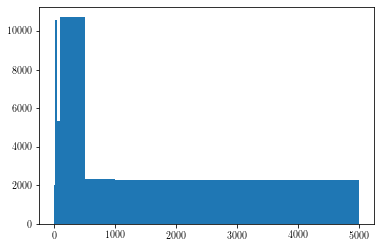

In [58]:
plt.hist(lens, bins=[-0.5, 0.5, 1.5, 5, 10, 50, 100, 500, 1000, 5000])

In [59]:
sum(lens)

8513922

# CH consumption case study

In [8]:
# Read in CH HH consumption
CH_consumption_PRO = pd.read_excel('/home/jakobs/Documents/IndEcol/OASES/ConsumerModelCH/consumption_model/HABE_091011_database/CH_HH_consumption_1_month_all_2011.xlsx', index_col= 0)
# Scale HABE data with GDP growth (corrected for inflation and population growth)
# Population (permanent residents) growth in CH between 2011 and 2012 was 0.55% (+44,000 from 7,995,000)
Population_growth_2011_2012 = 1+44/7995
# GDP growth 2011-2012 is 2.2 % in previous year prices (i.e. inflation corrected)
# For households and non-profit institutions serving households
GDP_growth_HH_2011_2012 = 1 + 0.022  
GDP_growth_HH_2011_2012_population_corrected = GDP_growth_HH_2011_2012/Population_growth_2011_2012
# now increase the 
CH_consumption_PRO['Total supply CH HH consumption 1 month average'] *= GDP_growth_HH_2011_2012_population_corrected
x_CH_consumption_1_month_average = CH_consumption_PRO['Total supply CH HH consumption 1 month average'].values


In [211]:
Z_lca_HH_CH = hdb.A_lca.dot(np.diag(CH_consumption_PRO['Total supply CH HH consumption 1 month average'].values))

In [212]:
y_HH_CH = CH_consumption_PRO['Total supply CH HH consumption 1 month average'].values-Z_lca_HH_CH.sum(axis=1)

In [213]:
CH_consumption_PRO['Final Demand CH HH consumtion 1 month average'] = y_HH_CH

In [14]:
CH_consumption_PRO.loc[(y_HH_CH != 0)&(CH_consumption_PRO.geography=='CH'),['activityName','productName']]

,activityName,productName
ecoinvent UUID,,
b45ebf7e-9c37-43af-8031-3d52ff5dfe8f_a235b2ff-3237-44b0-a445-b852376a1939,"barley production, Swiss integrated production...","barley grain, Swiss integrated production"
b45ebf7e-9c37-43af-8031-3d52ff5dfe8f_d7f544d6-c372-4fc3-81ae-44aa3614c9fc,"barley production, Swiss integrated production...",straw
bac2ed16-1594-40fb-9661-870b3211e4a1_d7f544d6-c372-4fc3-81ae-44aa3614c9fc,"barley production, Swiss integrated production...",straw
bac2ed16-1594-40fb-9661-870b3211e4a1_a235b2ff-3237-44b0-a445-b852376a1939,"barley production, Swiss integrated production...","barley grain, Swiss integrated production"
6469db8c-1e2a-4ead-a1c9-f71f2aef2f39_f467c4d0-ea1c-4ae3-8d69-712598a0478a,"barley production, organic","barley grain, organic"
...,...,...
9f786ad7-64f5-4e84-9210-95045408a1aa_1d32b849-121f-4d23-853c-fa2bf55c42e9,"market for land use change, annual crop","land use change, annual crop"
b4fc0ef9-46b3-4494-b6b6-2b7004a74c80_1576e293-dab0-42c9-a87b-74d001c1aae9,"packing, clay product","packing, clay product"
34979596-026f-4d28-8c75-e6a45e9a7166_8691615f-9152-44db-b3a1-98d7f87ae7a1,"packing, fibre cement product","packing, fibre cement product"


In [9]:
GWP100_CH_HH_Fix_Var = g['io_impacts/Global Warming Potential 100'][()] * CH_consumption_PRO['Total supply CH HH consumption 1 month average'].to_numpy()
GWP100_CH_HH_Var_Var = f['io_impacts/Global Warming Potential 100'][()] * CH_consumption_PRO['Total supply CH HH consumption 1 month average'].to_numpy()
GWP100_CH_HH_Var_Fix = h['io_impacts/Global Warming Potential 100'][()] * CH_consumption_PRO['Total supply CH HH consumption 1 month average'].to_numpy()

In [10]:
GWP100_CH_HH_lca = (hdb.C_lca[425,:].dot(hdb.F_lca)).A*CH_consumption_PRO['Total supply CH HH consumption 1 month average'].to_numpy()

In [11]:
results_CH_GWP100 = [GWP100_CH_HH_Var_Var, GWP100_CH_HH_Var_Fix, GWP100_CH_HH_Fix_Var]
names = ['Var-Var', 'Var-Fix', 'Fix-Var']

In [65]:
GWP100_CH_HH_lca[0,~X_CH_BACI_Hybrid_boolean_mask].sum()

1000.0051688461382

In [73]:
def Make_results_table(results_array, lca_results, masks, mask_names, footprint_name, sim_names, col_units=None, bins=None):
    
    col_names = 'Subset & $N_\mathrm{proc}$ & Simlation run & PLCA & \multicolumn{2}{c}{HLCA$_\mathrm{Baci}$} \\\\'
    if col_units is not None:
        pass
    else:
        col_units = ' & & {\small $\mathrm{Geography-Price}$} & {\small [$\mathrm{kg\ CO_2eq}$]}& {\small [$\mathrm{kg\ CO_2eq}$]} & {\small $\%$} \\\\'

    file_dir = '/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/documents/paper2/61bc2f9c494d37b5d3f0481a/Tables/'
    file_name = 'Results_Overview_CH_consumption_{}_varfix_mean_price.tex'.format(footprint_name.replace(' ',''))

    with open(os.path.join(file_dir, file_name), 'w') as fh:
        fh.write(r'\begin{tabular}{cccccc}')
        fh.write(r'\toprule'+'\n')
        fh.write(r'\hiderowcolors'+'\n')
        fh.write(col_names+'\n')    
        fh.write(col_units+'\midrule\midrule'+'\showrowcolors'+'\n')

        for j,(mask,mask_name) in enumerate(zip(masks, mask_names)):
            lca_impact = lca_results[0,mask].sum()
            
            for i in range(len(results_array)):
                if i==1:
                    Mask_name = mask_name
                    mask_len = sum(mask)
                else:
                    Mask_name = ''
                    mask_len = ''
                percentiles = np.percentile(results_array[i][:,mask].sum(axis=1), [2.5,16,50,84,97.5])
                table_string = '{0} & ${1}$ & $\mathrm{{{2}}}$ & ${3:.0f}$  & ${4:.0f}_{{-{5:.0f}}}^{{+{6:.0f}}}$ & ${7:.1f}_{{-{8:.1f}}}^{{+{9:.1f}}}$ \\\\'.format(
                        Mask_name, mask_len, sim_names[i], lca_impact, percentiles[2], 
                        (percentiles[2]-percentiles[0]), (percentiles[4]-percentiles[2]),
                        percentiles[2]/lca_impact*100, (percentiles[2]-percentiles[0])/lca_impact*100,
                        (percentiles[4]-percentiles[2])/lca_impact*100)
                fh.write(table_string+'\n')
                print(table_string)
            fh.write('\midrule'+'\n')
            print('\n')
                
        fh.write(r'\bottomrule')
        fh.write(r'\end{tabular}')

In [74]:
Make_results_table(results_CH_GWP100, GWP100_CH_HH_lca, [X_CH_boolean_mask, X_CH_BACI_Hybrid_boolean_mask, X_CH_hybrid_boolean_mask, X_CH_hybrid_BACI_Agg, X_CH_hybrid_Agg_boolean_mask, X_CH_BACI_hybrid_single_regions, X_CH_hybrid_single_regions],['All', 'BACI hybrid', 'Hybrid', 'BACI hybrid agg. reg.', 'Hybrid agg. reg.', 'BACI hybrid sin. reg.', 'Hybrid sin. reg.'], 'GWP 100', sim_names=names)

 & $$ & $\mathrm{Var-Var}$ & $1144$  & $96_{-31}^{+105}$ & $8.4_{-2.7}^{+9.2}$ \\
All & $12065$ & $\mathrm{Var-Fix}$ & $1144$  & $83_{-19}^{+26}$ & $7.2_{-1.6}^{+2.3}$ \\
 & $$ & $\mathrm{Fix-Var}$ & $1144$  & $77_{-21}^{+71}$ & $6.7_{-1.8}^{+6.2}$ \\


 & $$ & $\mathrm{Var-Var}$ & $144$  & $58_{-21}^{+82}$ & $40.0_{-14.6}^{+57.1}$ \\
BACI hybrid & $1151$ & $\mathrm{Var-Fix}$ & $144$  & $41_{-11}^{+25}$ & $28.8_{-7.8}^{+17.2}$ \\
 & $$ & $\mathrm{Fix-Var}$ & $144$  & $39_{-10}^{+46}$ & $27.0_{-7.0}^{+32.1}$ \\


 & $$ & $\mathrm{Var-Var}$ & $493$  & $96_{-31}^{+105}$ & $19.5_{-6.4}^{+21.3}$ \\
Hybrid & $3794$ & $\mathrm{Var-Fix}$ & $493$  & $83_{-19}^{+26}$ & $16.8_{-3.8}^{+5.2}$ \\
 & $$ & $\mathrm{Fix-Var}$ & $493$  & $77_{-21}^{+71}$ & $15.6_{-4.3}^{+14.4}$ \\


 & $$ & $\mathrm{Var-Var}$ & $114$  & $53_{-21}^{+82}$ & $46.3_{-18.1}^{+71.8}$ \\
BACI hybrid agg. reg. & $813$ & $\mathrm{Var-Fix}$ & $114$  & $37_{-11}^{+25}$ & $32.2_{-9.8}^{+21.6}$ \\
 & $$ & $\mathrm{Fix-Var}$ & $114$ 

In [76]:
def Make_results_df(results_array, lca_results, masks, mask_names, footprint_name, sim_names, col_units=None, bins=None):
    
    col_names = 'Subset & $N_\mathrm{proc}$ & Simlation run & PLCA & \multicolumn{2}{c}{HLCA$_\mathrm{Baci}$} \\\\'
    if col_units is not None:
        pass
    else:
        col_units = ' & & {\small Geography-Price} & {\small [$10^2\ \mathrm{kg\ CO_2eq}$]}& {\small [$10^2\ \mathrm{kg\ CO_2eq}$]} & {\small \%} \\\\'
    d = {}
    d['mask'] = []
    d['N proc'] = []
    d['sim'] = []
    d['lca impact'] = []
    d['io impact'] = []
    d['io low'] = []
    d['io high'] = []

    for j,(mask,mask_name) in enumerate(zip(masks, mask_names)):
        
        lca_impact = lca_results[0,mask].sum()
            
        for i in range(len(results_array)):
            percentiles = np.percentile(results_array[i][:,mask].sum(axis=1), [2.5,50,97.5])
            
            d['mask'].append(mask_name)
            d['N proc'].append(sum(mask))
            d['sim'].append(sim_names[i])
            d['lca impact'].append(lca_impact)
            d['io impact'].append(percentiles[1])
            d['io low'].append(percentiles[0])
            d['io high'].append(percentiles[2])
            
    df = pd.DataFrame.from_dict(d)
    return df
                

In [39]:
df = Make_results_df(results_CH_GWP100, GWP100_CH_HH_lca, [X_CH_boolean_mask, X_CH_BACI_Hybrid_boolean_mask, X_CH_hybrid_boolean_mask, X_CH_hybrid_BACI_Agg, X_CH_hybrid_Agg_boolean_mask],['All', 'BACI hybrid', 'Hybrid', 'BACI hybrid agg. reg.', 'Hybrid agg. reg.'], 'GWP 100', sim_names=names)
df

,mask,N proc,sim,lca impact,io impact,io low,io high
0,All,12065,Var-Var,1143.891978,96.341079,65.021573,201.400777
1,All,12065,Var-Fix,1143.891978,56.728094,45.038505,74.450602
2,All,12065,Fix-Var,1143.891978,77.011882,55.922267,148.019571
3,BACI hybrid,1151,Var-Var,143.886810,57.605955,36.655116,139.700066
4,BACI hybrid,1151,Var-Fix,143.886810,29.748333,21.537365,46.966645
5,BACI hybrid,1151,Fix-Var,143.886810,38.904027,28.814988,85.088293
6,Hybrid,3794,Var-Var,492.968976,96.341079,65.021573,201.400777
7,Hybrid,3794,Var-Fix,492.968976,56.728094,45.038505,74.450602
8,Hybrid,3794,Fix-Var,492.968976,77.011882,55.922267,148.019571
9,BACI hybrid agg. reg.,259,Var-Var,8.426058,5.614436,2.687770,19.525502


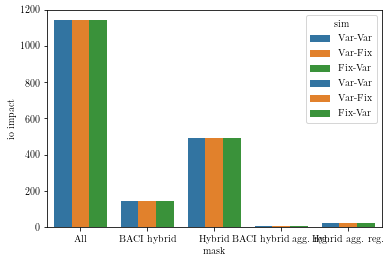

In [48]:
sns.barplot(x='mask', y='lca impact', hue='sim', data=df)


In [42]:
from plotly import graph_objects as go

In [ ]:
fig = go.Figure()
obj = go.Bar(x=)

In [25]:
def paper_subplots(GWP_array, GWP_lca, LU_array, LU_lca, mask, footprint_names):
    rc('font',**{'family':'DejaVu Sans', 'size':18})                                            
    rc('text', usetex=True)
    data_dic = {}
    data_dic['impact'] = []
    data_dic['data set'] = []
    data_dic['median'] = []
    data_dic['values'] = []
    fig, axes = plt.subplots(1,2, figsize=(13,4))
    for j,(ax, results_array, lca_results, footprint_name) in enumerate(zip(axes.flatten(), [GWP_array, LU_array],[GWP_lca, LU_lca], footprint_names)):
        dists = []
        x_max = []
        for i in range(3):
            dist = results_array[i][:,mask].sum(axis=1)/lca_results[0,mask].sum()*100
            dists.append(dist)
            ax.axvline(np.median(dist), color=c[i], linestyle='--', lw=1.5)
            p = np.percentile(dist, [2.5,16,50,84,97.5])
            print(names[i], '({:.1f}%, {:.1f}%, +{:.1f}%), (-{:.0f}%,+{:.0f}%)'.format(p[0]-p[2],p[2],p[4]-p[2],(p[2]-p[0])/p[2]*100, (p[4]-p[2])/p[2]*100))
            x_max.append(np.percentile(dist, 99))
        bins=np.linspace(0,np.max(x_max),30)
        data_dic['impact'].append(footprint_name)
        data_dic['data set'].append('bins')
        data_dic['values'].append(bins)
        data_dic['median'].append(np.nan)
        for i in range(3):
            ax.hist(dists[i], bins=bins, color=c[i], histtype='stepfilled', alpha=0.15, lw=2, density=True)
            values,_,_ = ax.hist(dists[i], bins=bins, color=c[i], label=names[i], histtype='step', lw=2, density=True)
            data_dic['impact'].append(footprint_name)
            data_dic['data set'].append(names[i])
            data_dic['values'].append(values)
            data_dic['median'].append(np.median(dist))
        ax.legend(frameon=False, title=r'{\large Geography-Price:}', prop={'size': 12})
        #ax.set_yscale('log')
        ax.set_xlabel(r'Relative increase in {} [\%]'.format(footprint_name))
        ax.set_ylabel(r'Probability Density')
        ax.set_xlim((0,np.max(x_max)))
    fig_name = '/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/plots/CH_HH_GWP100_LandUse_total.pdf'
    plt.savefig(fig_name, bbox_inches = 'tight', pad_inches = 0.01)
    plt.show()
    return data_dic

Var-Var (-2.7%, 8.4%, +9.2%), (-33%,+109%)
Var-Fix (-1.6%, 7.2%, +2.3%), (-22%,+31%)
Fix-Var (-1.8%, 6.7%, +6.2%), (-27%,+92%)
Var-Var (-14.8%, 37.7%, +67.5%), (-39%,+179%)
Var-Fix (-11.6%, 34.1%, +32.8%), (-34%,+96%)
Fix-Var (-9.5%, 33.7%, +34.3%), (-28%,+102%)


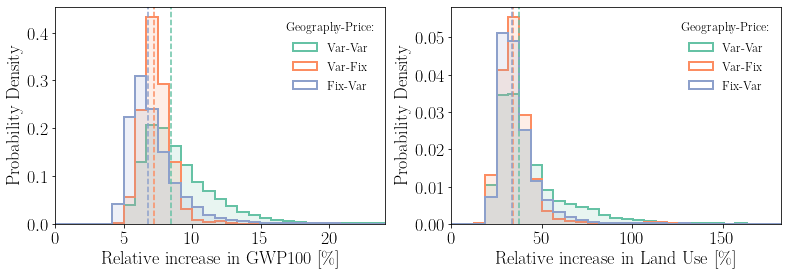

In [26]:
data_dic = paper_subplots(results_CH_GWP100, GWP100_CH_HH_lca, land_use_results, Land_Use_CH_HH_lca, X_CH_boolean_mask, footprint_names=['GWP100', 'Land Use'])

In [44]:
# Write data to excel file for suppl mat. 
df_full_dist = pd.DataFrame.from_dict(data_dic)


# new df from the column of lists
split_df = pd.DataFrame(df_full_dist['values'].tolist(), columns=['value {}'.format(i+1) for i in range(30)])
# concat df and split_df
df_full_dist = pd.concat([df_full_dist[['impact', 'data set', 'median']], split_df], axis=1)
# display df
df_full_dist

,impact,data set,median,value 1,value 2,value 3,value 4,value 5,value 6,value 7,...,value 21,value 22,value 23,value 24,value 25,value 26,value 27,value 28,value 29,value 30
0,GWP100,bins,NaN,0.0,0.831169,1.662338,2.493508,3.324677,4.155846,4.987015,...,16.623384,17.454553,18.285722,19.116892,19.948061,20.779230,21.610399,22.441568,23.272737,24.103907
1,GWP100,Var-Var,6.732444,0.0,0.000000,0.000000,0.000000,0.000000,0.001701,0.039618,...,0.005833,0.003524,0.002431,0.002917,0.001944,0.001823,0.002674,0.002187,0.001944,NaN
2,GWP100,Var-Fix,6.732444,0.0,0.000000,0.000000,0.000000,0.000000,0.002045,0.057269,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
3,GWP100,Fix-Var,6.732444,0.0,0.000000,0.000000,0.000000,0.000121,0.042270,0.224514,...,0.001449,0.001812,0.001208,0.001449,0.001208,0.000604,0.000604,0.000604,0.000362,NaN
4,Land Use,bins,NaN,0.0,6.279186,12.558373,18.837559,25.116745,31.395932,37.675118,...,125.583726,131.862913,138.142099,144.421285,150.700472,156.979658,163.258844,169.538031,175.817217,182.096403
5,Land Use,Var-Var,33.745075,0.0,0.000000,0.000096,0.010362,0.034533,0.034886,0.025134,...,0.000160,0.000241,0.000305,0.000176,0.000112,0.000144,0.000048,0.000048,0.000064,NaN
6,Land Use,Var-Fix,33.745075,0.0,0.000000,0.000129,0.013046,0.041326,0.055531,0.029245,...,0.000048,0.000016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000080,NaN
7,Land Use,Fix-Var,33.745075,0.0,0.000000,0.000000,0.007258,0.051235,0.049130,0.025283,...,0.000144,0.000080,0.000064,0.000112,0.000016,0.000032,0.000000,0.000032,0.000032,NaN


In [45]:
df_full_dist.to_excel('/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/plots/plot_data/CH_truncation_error_full_dist_GWP100_LandUse.xlsx')

In [38]:
def Plot_total_distribution(results_array, lca_results, masks, mask_names, footprint_name, bins=None, save=True):
    rc('font',**{'family':'DejaVu Sans', 'size':18})                                            
    rc('text', usetex=True)

    for j,(mask, name) in enumerate(zip(masks, mask_names)):
        print(name, ', # Processes:', sum(mask))
        fig = plt.figure()
        ax = fig.add_subplot(111)
        dists = []
        x_max = []
        for i in range(3):
            dist = results_array[i][:,mask].sum(axis=1)/lca_results[0,mask].sum()*100
            dists.append(dist)
            ax.axvline(np.median(dist), color=c[i], linestyle='--', lw=1.5)
            p = np.percentile(dist, [2.5,16,50,84,97.5])
            print(names[i], '({:.1f}%, {:.1f}%, +{:.1f}%), (-{:.0f}%,+{:.0f}%)'.format(p[0]-p[2],p[2],p[4]-p[2],(p[2]-p[0])/p[2]*100, (p[4]-p[2])/p[2]*100))
            x_max.append(np.percentile(dist, 99))
        bins=np.linspace(0,np.max(x_max),30)
        for i in range(3):
            ax.hist(dists[i], bins=bins, color=c[i], histtype='stepfilled', alpha=0.15, lw=2, density=True)
            ax.hist(dists[i], bins=bins, color=c[i], label=names[i], histtype='step', lw=2, density=True)
        ax.legend(frameon=False, title=r'{\large Geography-Price:}', prop={'size': 12})
        #ax.set_yscale('log')
        ax.set_xlabel(r'Relative increase in {} [\%]'.format(footprint_name))
        ax.set_ylabel(r'Probability Density')
        ax.set_xlim((0,np.max(x_max)))
        if (j==0) and (save==True):
            print('saving figure...')
            fig_name = '/home/jakobs/Documents/IndEcol/OASES/Geographic_uncertainty/plots/CH_HH_{}_total.pdf'.format(footprint_name.replace(' ',''))
            plt.savefig(fig_name, bbox_inches = 'tight', pad_inches = 0.01)
        plt.show()

All , # Processes: 12065
Var-Var (-2.7%, 8.4%, +9.2%), (-33%,+109%)
Var-Fix (-1.6%, 7.2%, +2.3%), (-22%,+31%)
Fix-Var (-1.8%, 6.7%, +6.2%), (-27%,+92%)
saving figure...


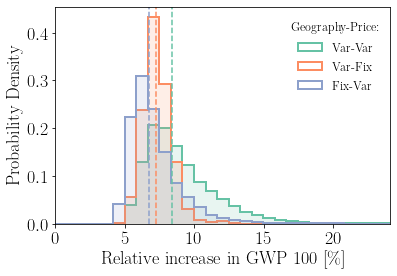

BACI Hybrid , # Processes: 1151
Var-Var (-14.6%, 40.0%, +57.1%), (-36%,+143%)
Var-Fix (-7.8%, 28.8%, +17.2%), (-27%,+60%)
Fix-Var (-7.0%, 27.0%, +32.1%), (-26%,+119%)


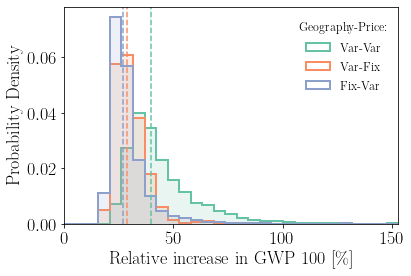

Hybrid , # Processes: 3794
Var-Var (-6.4%, 19.5%, +21.3%), (-33%,+109%)
Var-Fix (-3.8%, 16.8%, +5.2%), (-22%,+31%)
Fix-Var (-4.3%, 15.6%, +14.4%), (-27%,+92%)


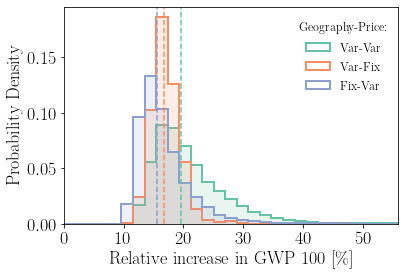

BACI Hybrid Aggregate Regions , # Processes: 813
Var-Var (-18.1%, 46.3%, +71.8%), (-39%,+155%)
Var-Fix (-9.8%, 32.2%, +21.6%), (-30%,+67%)
Fix-Var (-8.6%, 30.0%, +40.2%), (-29%,+134%)


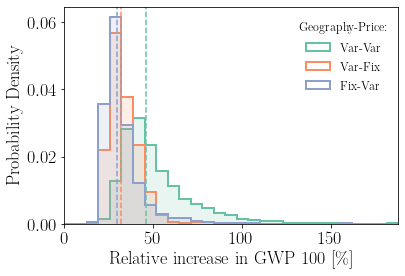

Hybrid Aggregate Regions , # Processes: 1573
Var-Var (-15.1%, 40.5%, +51.0%), (-37%,+126%)
Var-Fix (-9.0%, 33.9%, +12.5%), (-27%,+37%)
Fix-Var (-10.0%, 31.1%, +34.6%), (-32%,+111%)


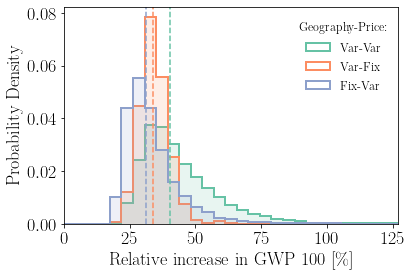

BACI Hybrid Single Regions , # Processes: 338
Var-Var (-2.9%, 15.2%, +5.6%), (-19%,+37%)
Var-Fix (0.0%, 15.7%, +0.0%), (-0%,+0%)
Fix-Var (-2.9%, 15.2%, +6.2%), (-19%,+41%)


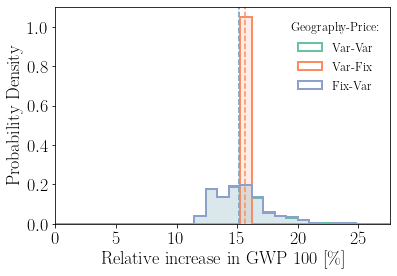

Hybrid Single Regions , # Processes: 2221
Var-Var (-0.7%, 4.4%, +1.2%), (-15%,+27%)
Var-Fix (-0.0%, 4.5%, +0.0%), (-0%,+0%)
Fix-Var (-0.7%, 4.4%, +1.3%), (-15%,+30%)


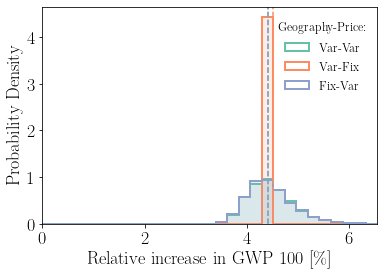

In [39]:
Plot_total_distribution(results_CH_GWP100, GWP100_CH_HH_lca,[X_CH_boolean_mask, X_CH_BACI_Hybrid_boolean_mask, X_CH_hybrid_boolean_mask, X_CH_hybrid_BACI_Agg, X_CH_hybrid_Agg_boolean_mask, X_CH_BACI_hybrid_single_regions, X_CH_hybrid_single_regions],['All', 'BACI Hybrid', 'Hybrid', 'BACI Hybrid Aggregate Regions', 'Hybrid Aggregate Regions', 'BACI Hybrid Single Regions', 'Hybrid Single Regions'], 'GWP 100')


# Now for counter factual final demand from DE, RER, RoW if possible

In [101]:
try:
    del Land_Use_CH_HH_Var_Var_CF
    del Land_Use_CH_HH_Fix_Var_CF
    del Land_Use_CH_HH_Var_Fix_CF
except NameError:
    print("Did not yet exist")

Did not yet exist


In [102]:
try:
    del GWP100_CH_HH_Var_Var_CF
    del GWP100_CH_HH_Fix_Var_CF
    del GWP100_CH_HH_Var_Fix_CF
except NameError:
    print("Did not yet exist")

Did not yet exist


In [259]:
GWP100_CH_HH_Var_Var_CF = f['io_impacts/Global Warming Potential 100'][()] * CH_consumption_PRO['Total supply Counter Factual 1 month average'].to_numpy()

In [260]:
GWP100_CH_HH_Fix_Var_CF = g['io_impacts/Global Warming Potential 100'][()] * CH_consumption_PRO['Total supply Counter Factual 1 month average'].to_numpy()

In [261]:
GWP100_CH_HH_Var_Fix_CF = h['io_impacts/Global Warming Potential 100'][()] * CH_consumption_PRO['Total supply Counter Factual 1 month average'].to_numpy()

In [275]:
results_counter_factual = [GWP100_CH_HH_Var_Var_CF, GWP100_CH_HH_Var_Fix_CF, GWP100_CH_HH_Fix_Var_CF]
names = ['Var-Var', 'Var-Fix', 'Fix-Var']

In [279]:
del results_counter_factual

In [239]:
GWP100_CH_HH_lca_CF = (hdb.C_lca[425,:].dot(hdb.F_lca)).A*CH_consumption_PRO['Total supply Counter Factual 1 month average'].to_numpy()

All , # Processes: 12124
Var-Var (-4.5%, 9.9%, +21.2%), (-46%,+215%)
Var-Fix (-1.4%, 6.0%, +1.9%), (-23%,+32%)
Fix-Var (-1.6%, 5.5%, +5.6%), (-29%,+101%)


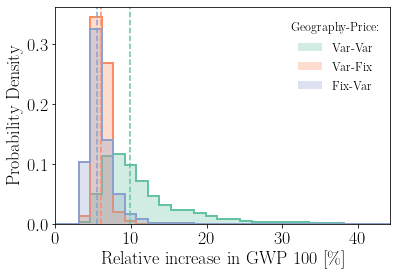

BACI Hybrid , # Processes: 1160
Var-Var (-35.2%, 65.2%, +187.8%), (-54%,+288%)
Var-Fix (-7.6%, 29.5%, +16.5%), (-26%,+56%)
Fix-Var (-7.1%, 27.2%, +34.8%), (-26%,+128%)


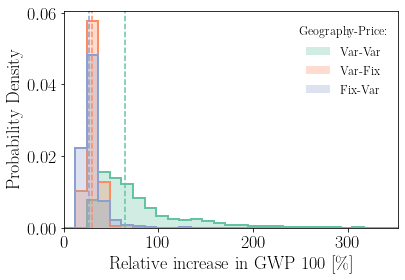

Hybrid , # Processes: 3811
Var-Var (-8.8%, 19.0%, +41.0%), (-46%,+215%)
Var-Fix (-2.7%, 11.6%, +3.7%), (-23%,+32%)
Fix-Var (-3.1%, 10.7%, +10.8%), (-29%,+101%)


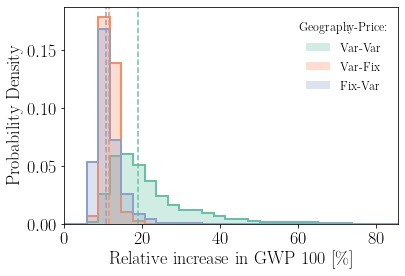

BACI Hybrid Aggregate Regions , # Processes: 262
Var-Var (-247.7%, 291.2%, +2073.4%), (-85%,+712%)
Var-Fix (-14.7%, 46.6%, +21.4%), (-32%,+46%)
Fix-Var (-9.4%, 36.4%, +76.3%), (-26%,+210%)


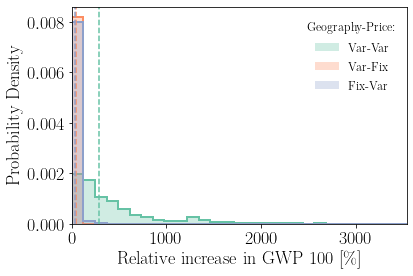

Hybrid Aggregate Regions , # Processes: 466
Var-Var (-36.4%, 45.9%, +290.8%), (-79%,+634%)
Var-Fix (-3.9%, 11.8%, +4.9%), (-33%,+42%)
Fix-Var (-3.3%, 9.6%, +19.0%), (-35%,+197%)


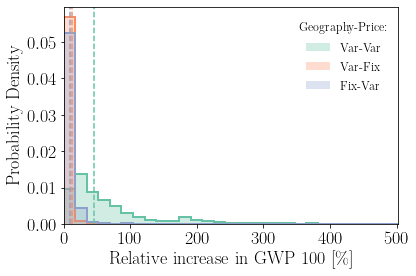

In [276]:
Plot_total_distribution(results_counter_factual, GWP100_CH_HH_lca_CF, [X_counter_factual_boolean_mask, X_counter_factual_BACI_Hybrid_boolean_mask, X_counter_factual_hybrid_boolean_mask, X_counter_factual_BACI_Hybrid_Agg, X_counter_factual_hybrid_Agg_boolean_mask],['All', 'BACI Hybrid', 'Hybrid', 'BACI Hybrid Aggregate Regions', 'Hybrid Aggregate Regions'], 'GWP 100', save=False)

# NOw counter factual Land Use

In [245]:
Land_Use_CH_HH_Fix_Var_CF = g['io_impacts/Land use'][()] * CH_consumption_PRO['Total supply Counter Factual 1 month average'].to_numpy()
Land_Use_CH_HH_Var_Var_CF = f['io_impacts/Land use'][()] * CH_consumption_PRO['Total supply Counter Factual 1 month average'].to_numpy()
Land_Use_CH_HH_Var_Fix_CF = h['io_impacts/Land use'][()] * CH_consumption_PRO['Total supply Counter Factual 1 month average'].to_numpy()

In [247]:
results_counter_factual_LandUse = [Land_Use_CH_HH_Var_Var_CF*1e6, Land_Use_CH_HH_Var_Fix_CF*1e6, Land_Use_CH_HH_Fix_Var_CF*1e6]

In [258]:
del results_counter_factual_LandUse

In [250]:
Land_Use_CH_HH_lca_CF = (hdb.C_lca[[711,737],:].dot(hdb.F_lca)).A*CH_consumption_PRO['Total supply Counter Factual 1 month average'].to_numpy()

All , # Processes: 12124
Var Var (-21.1%, 43.7%, +87.9%), (-48%,+201%)
Var Fix (-10.4%, 29.8%, +29.3%), (-35%,+98%)
Fix Var (-8.7%, 29.5%, +31.5%), (-30%,+107%)


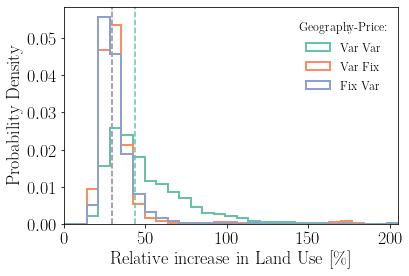

BACI Hybrid , # Processes: 1160
Var Var (-31.0%, 56.2%, +152.5%), (-55%,+271%)
Var Fix (-10.3%, 28.7%, +55.3%), (-36%,+192%)
Fix Var (-8.5%, 31.2%, +42.4%), (-27%,+136%)


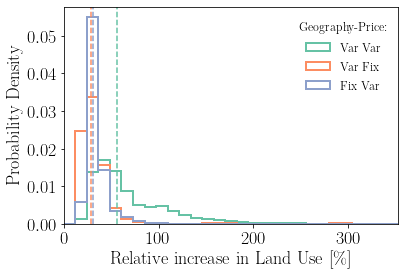

Hybrid , # Processes: 3811
Var Var (-27.9%, 57.8%, +116.3%), (-48%,+201%)
Var Fix (-13.8%, 39.4%, +38.8%), (-35%,+98%)
Fix Var (-11.5%, 39.0%, +41.8%), (-30%,+107%)


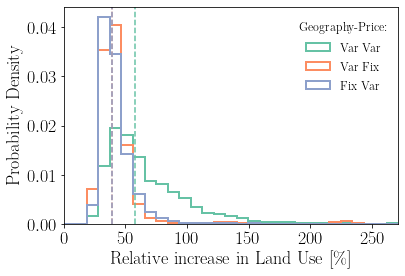

BACI Hybrid Aggregate Regions , # Processes: 262
Var Var (-31415552.2%, 36780748.7%, +245337857.3%), (-85%,+667%)
Var Fix (-1707493.2%, 5768740.4%, +3428522.9%), (-30%,+59%)
Fix Var (-995935.1%, 4616064.6%, +9059090.0%), (-22%,+196%)


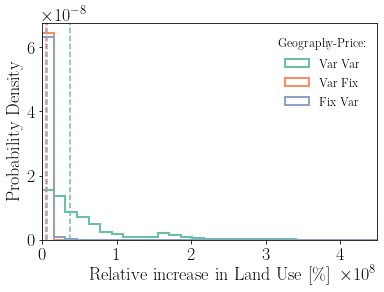

Hybrid Aggregate Regions , # Processes: 466
Var Var (-518341.1%, 651022.5%, +3919917.6%), (-80%,+602%)
Var Fix (-44680.2%, 154115.9%, +84078.4%), (-29%,+55%)
Fix Var (-39752.2%, 133157.8%, +205393.0%), (-30%,+154%)


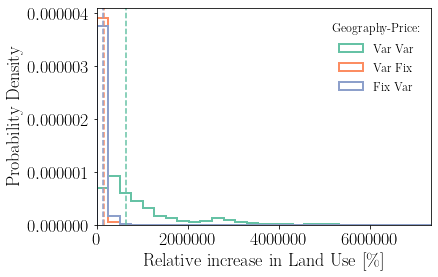

In [255]:
Plot_total_distribution(results_counter_factual_LandUse, Land_Use_CH_HH_lca_CF, [X_counter_factual_boolean_mask, X_counter_factual_BACI_Hybrid_boolean_mask, X_counter_factual_hybrid_boolean_mask, X_counter_factual_BACI_Hybrid_Agg, X_counter_factual_hybrid_Agg_boolean_mask],['All', 'BACI Hybrid', 'Hybrid', 'BACI Hybrid Aggregate Regions', 'Hybrid Aggregate Regions'], 'Land Use', save=False)

# NR of Processes per country in the supply chain of the CH consumption and counter factual case

In [54]:
[print(i[0],i[1][0],'\n') for i in CH_consumption_PRO.loc[X_counter_factual_hybrid_boolean_mask].groupby('geography').count().iterrows()]

ASCC 17 

AT 25 

AU 33 

BE 29 

BG 23 

BR 27 

CA 2 

CA-AB 21 

CA-BC 12 

CA-MB 8 

CA-NB 11 

CA-NF 5 

CA-NS 11 

CA-NT 6 

CA-NU 1 

CA-ON 17 

CA-PE 7 

CA-QC 100 

CA-SK 11 

CA-YK 2 

CH 277 

CN 40 

CN-AH 10 

CN-BJ 9 

CN-CQ 9 

CN-FJ 10 

CN-GD 12 

CN-GS 9 

CN-GX 9 

CN-GZ 9 

CN-HA 9 

CN-HB 10 

CN-HE 10 

CN-HL 9 

CN-HN 10 

CN-HU 10 

CN-JL 9 

CN-JS 12 

CN-JX 9 

CN-LN 11 

CN-NM 9 

CN-NX 9 

CN-QH 9 

CN-SA 9 

CN-SC 9 

CN-SD 10 

CN-SH 11 

CN-SX 10 

CN-TJ 9 

CN-XJ 9 

CN-XZ 6 

CN-YN 9 

CN-ZJ 11 

CY 7 

CZ 28 

Canada without Quebec 4 

DE 80 

DK 20 

EE 16 

ES 40 

Europe without Switzerland 66 

Europe, without Russia and Turkey 1 

FI 30 

FR 40 

FRCC 23 

GB 27 

GLO 270 

GR 20 

HICC 17 

HR 20 

HU 25 

IAI Area, Africa 2 

IAI Area, Asia, without China and GCC 3 

IAI Area, EU27 & EFTA 5 

IAI Area, Gulf Cooperation Council 2 

IAI Area, Russia & RER w/o EU27 & EFTA 5 

IAI Area, South America 5 

ID 15 

IE 17 

IN 15 

IN-AP 6 

IN-AR 1 

I

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [53]:
[print(i[0],i[1][0],'\n') for i in CH_consumption_PRO.loc[X_CH_hybrid_boolean_mask].groupby('geography').count().iterrows()]

ASCC 17 

AT 25 

AU 33 

BE 29 

BG 23 

BR 27 

CA 2 

CA-AB 21 

CA-BC 12 

CA-MB 8 

CA-NB 11 

CA-NF 5 

CA-NS 11 

CA-NT 6 

CA-NU 1 

CA-ON 17 

CA-PE 7 

CA-QC 99 

CA-SK 11 

CA-YK 2 

CH 281 

CN 40 

CN-AH 10 

CN-BJ 9 

CN-CQ 9 

CN-FJ 10 

CN-GD 12 

CN-GS 9 

CN-GX 9 

CN-GZ 9 

CN-HA 9 

CN-HB 10 

CN-HE 10 

CN-HL 9 

CN-HN 10 

CN-HU 10 

CN-JL 9 

CN-JS 12 

CN-JX 9 

CN-LN 11 

CN-NM 9 

CN-NX 9 

CN-QH 9 

CN-SA 9 

CN-SC 9 

CN-SD 10 

CN-SH 11 

CN-SX 10 

CN-TJ 9 

CN-XJ 9 

CN-XZ 6 

CN-YN 9 

CN-ZJ 11 

CY 7 

CZ 28 

Canada without Quebec 4 

DE 80 

DK 20 

EE 16 

ES 40 

Europe without Switzerland 63 

Europe, without Russia and Turkey 1 

FI 30 

FR 38 

FRCC 23 

GB 27 

GLO 270 

GR 20 

HICC 17 

HR 20 

HU 25 

IAI Area, Africa 2 

IAI Area, Asia, without China and GCC 3 

IAI Area, EU27 & EFTA 5 

IAI Area, Gulf Cooperation Council 2 

IAI Area, Russia & RER w/o EU27 & EFTA 5 

IAI Area, South America 5 

ID 15 

IE 17 

IN 15 

IN-AP 6 

IN-AR 1 

IN

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [124]:
g.visititems(print)

io_impacts <HDF5 group "/io_impacts" (3 members)>
io_impacts/Global Warming Potential 100 <HDF5 dataset "Global Warming Potential 100": shape (10000, 16022), type "<f8">
io_impacts/Land use <HDF5 dataset "Land use": shape (10000, 16022), type "<f8">
io_impacts/Water Consumption Blue - Total <HDF5 dataset "Water Consumption Blue - Total": shape (10000, 16022), type "<f8">
lca_impacts <HDF5 dataset "lca_impacts": shape (879, 16022), type "<f8">


# Land Use Footprint CH HH

In [12]:
Land_Use_CH_HH_Fix_Var = g['io_impacts/Land use'][()] * CH_consumption_PRO['Total supply CH HH consumption 1 month average'].to_numpy()
Land_Use_CH_HH_Var_Var = f['io_impacts/Land use'][()] * CH_consumption_PRO['Total supply CH HH consumption 1 month average'].to_numpy()
Land_Use_CH_HH_Var_Fix = h['io_impacts/Land use'][()] * CH_consumption_PRO['Total supply CH HH consumption 1 month average'].to_numpy()

In [13]:
Land_Use_CH_HH_lca = (hdb.C_lca[[711,737],:].dot(hdb.F_lca)).A * CH_consumption_PRO['Total supply CH HH consumption 1 month average'].to_numpy()


In [41]:
Land_Use_CH_HH_lca.sum(axis=0)

array([2.27060673e-04, 1.24797450e-06, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [29]:
Land_Use_CH_HH_lca[:,X_CH_hybrid_boolean_mask].sum()

241.7830402324468

In [14]:
land_use_results = [Land_Use_CH_HH_Var_Var*1e6, Land_Use_CH_HH_Var_Fix*1e6, Land_Use_CH_HH_Fix_Var*1e6]


In [75]:
col_units = ' & & {\small $\mathrm{Geography-Price}$} & {\small [$\mathrm{m^2}$]}& {\small [$\mathrm{m^2}$]} & {\small $\%$} \\\\'
Make_results_table(land_use_results, Land_Use_CH_HH_lca.sum(axis=0).reshape(1,16022), [X_CH_boolean_mask, X_CH_BACI_Hybrid_boolean_mask, X_CH_hybrid_boolean_mask, X_CH_hybrid_BACI_Agg, X_CH_hybrid_Agg_boolean_mask, X_CH_BACI_hybrid_single_regions, X_CH_hybrid_single_regions],['All', 'BACI hybrid', 'Hybrid', 'BACI hybrid agg. reg.', 'Hybrid agg. reg.', 'BACI hybrid sin. reg.', 'Hybrid sin. reg.'], 'LandUse', sim_names=names, col_units=col_units)

 & $$ & $\mathrm{Var-Var}$ & $330$  & $117_{-46}^{+210}$ & $35.5_{-13.9}^{+63.5}$ \\
All & $12065$ & $\mathrm{Var-Fix}$ & $330$  & $106_{-36}^{+102}$ & $32.0_{-10.9}^{+30.9}$ \\
 & $$ & $\mathrm{Fix-Var}$ & $330$  & $105_{-30}^{+107}$ & $31.7_{-8.9}^{+32.3}$ \\


 & $$ & $\mathrm{Var-Var}$ & $166$  & $67_{-28}^{+184}$ & $40.4_{-17.1}^{+110.8}$ \\
BACI hybrid & $1151$ & $\mathrm{Var-Fix}$ & $166$  & $51_{-19}^{+102}$ & $30.8_{-11.4}^{+61.4}$ \\
 & $$ & $\mathrm{Fix-Var}$ & $166$  & $56_{-15}^{+75}$ & $33.8_{-9.2}^{+45.1}$ \\


 & $$ & $\mathrm{Var-Var}$ & $242$  & $117_{-46}^{+210}$ & $48.5_{-19.0}^{+86.8}$ \\
Hybrid & $3794$ & $\mathrm{Var-Fix}$ & $242$  & $106_{-36}^{+102}$ & $43.8_{-15.0}^{+42.2}$ \\
 & $$ & $\mathrm{Fix-Var}$ & $242$  & $105_{-30}^{+107}$ & $43.4_{-12.2}^{+44.1}$ \\


 & $$ & $\mathrm{Var-Var}$ & $75$  & $60_{-28}^{+185}$ & $80.2_{-37.7}^{+245.8}$ \\
BACI hybrid agg. reg. & $813$ & $\mathrm{Var-Fix}$ & $75$  & $44_{-19}^{+102}$ & $59.0_{-25.1}^{+135.6}$ \\
 & $$ & $

All , # Processes: 12065
Var-Var (-13.9%, 35.5%, +63.5%), (-39%,+179%)
Var-Fix (-10.9%, 32.0%, +30.9%), (-34%,+96%)
Fix-Var (-8.9%, 31.7%, +32.3%), (-28%,+102%)
saving figure...


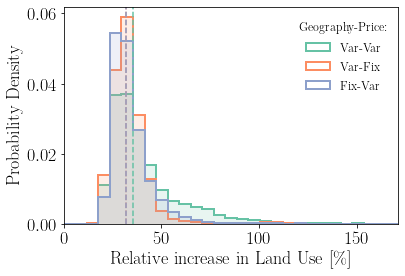

BACI Hybrid , # Processes: 1151
Var-Var (-17.1%, 40.4%, +110.8%), (-42%,+275%)
Var-Fix (-11.4%, 30.8%, +61.4%), (-37%,+200%)
Fix-Var (-9.2%, 33.8%, +45.1%), (-27%,+133%)


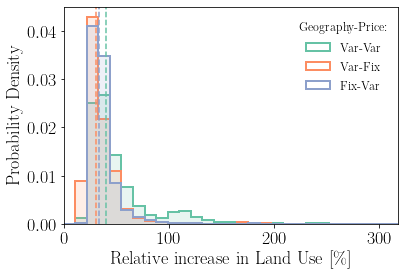

Hybrid , # Processes: 3794
Var-Var (-19.0%, 48.5%, +86.8%), (-39%,+179%)
Var-Fix (-15.0%, 43.8%, +42.2%), (-34%,+96%)
Fix-Var (-12.2%, 43.4%, +44.1%), (-28%,+102%)


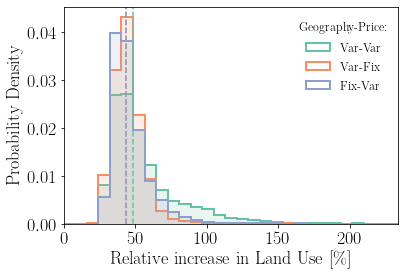

BACI Hybrid Aggregate Regions , # Processes: 813
Var-Var (-37.7%, 80.2%, +245.8%), (-47%,+307%)
Var-Fix (-25.1%, 59.0%, +135.6%), (-43%,+230%)
Fix-Var (-20.0%, 65.7%, +100.0%), (-31%,+152%)


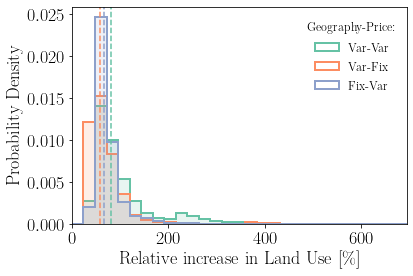

Hybrid Aggregate Regions , # Processes: 1573
Var-Var (-42.8%, 94.0%, +196.4%), (-46%,+209%)
Var-Fix (-33.9%, 83.3%, +95.6%), (-41%,+115%)
Fix-Var (-27.4%, 82.4%, +99.9%), (-33%,+121%)


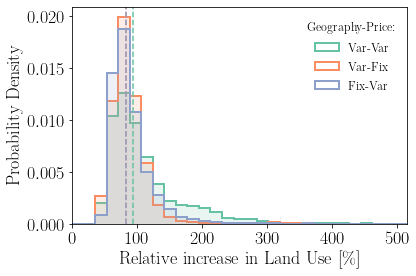

BACI Hybrid Single Regions , # Processes: 338
Var-Var (-1.7%, 7.4%, +2.3%), (-22%,+31%)
Var-Fix (0.0%, 7.4%, +0.0%), (-0%,+0%)
Fix-Var (-1.7%, 7.4%, +2.5%), (-22%,+34%)


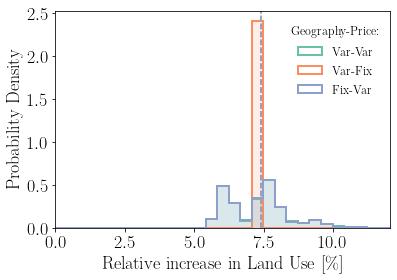

Hybrid Single Regions , # Processes: 2221
Var-Var (-1.9%, 12.3%, +3.5%), (-15%,+28%)
Var-Fix (-0.0%, 12.6%, +0.0%), (-0%,+0%)
Fix-Var (-1.9%, 12.3%, +3.8%), (-16%,+31%)


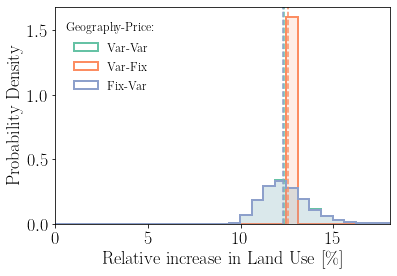

In [40]:
Plot_total_distribution(land_use_results, Land_Use_CH_HH_lca.sum(axis=0).reshape(1,16022), [X_CH_boolean_mask, X_CH_BACI_Hybrid_boolean_mask, X_CH_hybrid_boolean_mask, X_CH_hybrid_BACI_Agg, X_CH_hybrid_Agg_boolean_mask, X_CH_BACI_hybrid_single_regions, X_CH_hybrid_single_regions],['All', 'BACI Hybrid', 'Hybrid', 'BACI Hybrid Aggregate Regions', 'Hybrid Aggregate Regions', 'BACI Hybrid Single Regions', 'Hybrid Single Regions'], 'Land Use')

In [48]:
X_CH_hybrid_single_regions.sum()

2221

# Water consumption

In [ ]:
Water_CH_HH_Var_Var = f['io_impacts/Water Consumption Blue - Total'][()] * CH_consumption_PRO['Total supply CH HH consumption 1 month average'].to_numpy()
Water_CH_HH_Fix_Var = g['io_impacts/Water Consumption Blue - Total'][()] * CH_consumption_PRO['Total supply CH HH consumption 1 month average'].to_numpy()
Water_CH_HH_Var_Fix = h['io_impacts/Water Consumption Blue - Total'][()] * CH_consumption_PRO['Total supply CH HH consumption 1 month average'].to_numpy()

In [201]:
hdb.PRO.loc[~hdb.PRO['activityName'].str.contains('market')].groupby('activityName').size()

activityName
1,1-difluoroethane production, HFC-152a    2
1-propanol production                      2
2,4-di-tert-butylphenol production         1
2,4-dichlorophenol production              2
2,4-dichlorotoluene production             2
                                          ..
zinc oxide production                      2
zinc sulfide production                    4
zinc-lead mine operation                   2
zirconium oxide production                 2
zucchini production                        1
Length: 3637, dtype: int64

In [202]:
hdb.PRO.loc[~hdb.PRO['activityName'].str.contains('market')&~hdb.PRO['geography'].isin(list(hdb.countries_per_region.keys())+['RoW'])].groupby('activityName').size().sum()

5644

In [181]:
hdb.PRO.loc[~hdb.PRO['activityName'].str.contains('market')&hdb.PRO['geography'].isin(list(hdb.countries_per_region.keys())+['RoW'])].groupby('activityName').size()

activityName
1,1-difluoroethane production, HFC-152a    1
1-propanol production                      2
2,4-di-tert-butylphenol production         1
2,4-dichlorophenol production              2
2,4-dichlorotoluene production             2
                                          ..
zinc oxide production                      2
zinc sulfide production                    4
zinc-lead mine operation                   2
zirconium oxide production                 1
zucchini production                        1
Length: 3302, dtype: int64

In [192]:
len(set(hdb.PRO.loc[~hdb.PRO['activityName'].str.contains('market')&hdb.PRO['geography'].isin(list(hdb.countries_per_region.keys())+['RoW'])].groupby('activityName').size().index)-\
   set(hdb.PRO.loc[~hdb.PRO['activityName'].str.contains('market')&~hdb.PRO['geography'].isin(list(hdb.countries_per_region.keys())+['RoW'])].groupby('activityName').size().index))

1862

In [78]:
region_count = hdb.PRO.loc[~hdb.PRO['activityName'].str.contains('market')].groupby('geography').size()

In [93]:
aggregate_regions.remove('ENTSO-E')

In [104]:
region_count.loc[aggregate_regions+['GLO','RoW']].sum()

5316

In [144]:
# region_count.loc[region_count.index.isin(list(hdb.countries_per_region.keys())+['RoW'])]
region_count.loc[region_count.index.isin(list(hdb.countries_per_region.keys()))]#.sum()-927 # 927 GLO processes

geography
Europe without Switzerland                 201
GLO                                        927
IAI Area, Asia, without China and GCC       10
IAI Area, EU27 & EFTA                       20
IAI Area, Gulf Cooperation Council           7
IAI Area, Russia & RER w/o EU27 & EFTA      11
NORDEL                                       3
RAF                                          1
RAS                                          3
RER                                       1197
RER w/o CH+DE                                3
RER w/o DE+NL+RU                             1
RLA                                         20
RNA                                         30
UCTE                                         4
UCTE without Germany                         2
UN-OCEANIA                                  10
WEU                                          2
dtype: int64

In [39]:
for item in region_count.sort_values(ascending=False).items():
    print(item)


('RoW', 2866)
('CH', 1357)
('RER', 1197)
('GLO', 927)
('CA-QC', 376)
('Europe without Switzerland', 201)
('DE', 165)
('US', 115)
('CN', 86)
('FR', 85)
('SE', 75)
('RU', 71)
('BR', 67)
('ES', 67)
('NL', 66)
('IT', 63)
('ZA', 55)
('PE', 55)
('AT', 51)
('GB', 51)
('BE', 50)
('TR', 50)
('AU', 49)
('FI', 47)
('PL', 47)
('HU', 47)
('CZ', 45)
('SK', 43)
('CA-AB', 43)
('NO', 42)
('BG', 42)
('IN', 41)
('KR', 39)
('UA', 38)
('MX', 37)
('HR', 37)
('PT', 36)
('DK', 36)
('RO', 36)
('CA-ON', 34)
('GR', 34)
('TW', 34)
('WECC, US only', 34)
('NPCC, US only', 32)
('CA-NB', 32)
('JP', 32)
('CA-NS', 32)
('ID', 31)
('RNA', 30)
('SERC', 30)
('RS', 29)
('LV', 29)
('RFC', 29)
('LU', 28)
('LT', 28)
('MY', 28)
('CL', 28)
('TRE', 28)
('MRO, US only', 28)
('CA-PE', 28)
('IE', 27)
('SI', 27)
('FRCC', 27)
('EE', 26)
('TH', 26)
('SPP', 26)
('HICC', 23)
('CA-SK', 22)
('ASCC', 22)
('IR', 22)
('CA-MB', 21)
('BA', 20)
('CN-GD', 20)
('IAI Area, EU27 & EFTA', 20)
('RLA', 20)
('CA-BC', 20)
('CN-SH', 18)
('MK', 18)
('CA-NT

In [128]:
aggregate_regions

['RER',
 'Europe without Switzerland',
 'RLA',
 'Europe, without Russia and Turkey',
 'RME',
 'RAF',
 'RAS',
 'NORDEL',
 'WECC',
 'IAI Area, South America',
 'IAI Area, EU27 & EFTA',
 'UN-OCEANIA',
 'IAI Area, Asia, without China and GCC',
 'IAI Area, Russia & RER w/o EU27 & EFTA',
 'WEU',
 'UCTE',
 'UCTE without Germany',
 'RER w/o CH+DE',
 'IAI Area, Africa',
 'IAI Area, Gulf Cooperation Council',
 'RER w/o DE+NL+RU',
 'CENTREL']

In [129]:
hdb.countries_per_region.keys()

dict_keys(['Europe without Switzerland', 'GLO', 'IAI Area, Asia, without China and GCC', 'IAI Area, EU27 & EFTA', 'IAI Area, Gulf Cooperation Council', 'IAI Area, Russia & RER w/o EU27 & EFTA', 'NORDEL', 'RAF', 'RAS', 'RER', 'RER w/o CH+DE', 'RER w/o DE+NL+NO', 'RER w/o DE+NL+RU', 'RLA', 'RNA', 'UCTE', 'UCTE without Germany', 'UN-OCEANIA', 'WEU'])

In [137]:
region_count_hybrid_processes.loc[region_count_hybrid_processes.index.isin(list(hdb.countries_per_region.keys()))]

geography
Europe without Switzerland                 74
GLO                                       374
IAI Area, Asia, without China and GCC       5
IAI Area, EU27 & EFTA                       5
IAI Area, Gulf Cooperation Council          3
IAI Area, Russia & RER w/o EU27 & EFTA      5
NORDEL                                      1
RAF                                         1
RAS                                         3
RER                                       526
RER w/o CH+DE                               2
RER w/o DE+NL+RU                            1
RLA                                         8
RNA                                        11
UCTE                                        3
UCTE without Germany                        1
UN-OCEANIA                                  4
dtype: int64

In [138]:
region_count_hybrid_processes.loc[region_count_hybrid_processes.index.isin(aggregate_regions+['GLO'])]


geography
Europe without Switzerland                 74
Europe, without Russia and Turkey           1
GLO                                       374
IAI Area, Africa                            3
IAI Area, Asia, without China and GCC       5
IAI Area, EU27 & EFTA                       5
IAI Area, Gulf Cooperation Council          3
IAI Area, Russia & RER w/o EU27 & EFTA      5
IAI Area, South America                     5
NORDEL                                      1
RAF                                         1
RAS                                         3
RER                                       526
RER w/o CH+DE                               2
RER w/o DE+NL+RU                            1
RLA                                         8
UCTE                                        3
UCTE without Germany                        1
UN-OCEANIA                                  4
dtype: int64

In [121]:
region_count_hybrid_processes.loc['GLO'] 

374

In [115]:
region_count_hybrid_processes.loc['RoW'] 

1199

In [120]:
region_count_hybrid_processes.loc[region_count_hybrid_processes.index.isin(single_countries)].sum()

2873

In [85]:
region_count_hybrid_processes = hdb.PRO.loc[(hdb.PRO.index.isin(hdb.hybridized_processes))&(~hdb.PRO['activityName'].str.contains('market'))].groupby('geography').size()
for item in region_count_hybrid_processes.sort_values(ascending=False).items():
    print(item)


('RoW', 1199)
('RER', 526)
('CH', 430)
('GLO', 374)
('CA-QC', 138)
('DE', 94)
('Europe without Switzerland', 74)
('RU', 54)
('US', 49)
('NL', 45)
('FR', 44)
('CN', 43)
('ES', 43)
('SE', 42)
('BR', 39)
('AU', 39)
('IT', 38)
('GB', 37)
('KR', 33)
('TR', 32)
('CA-AB', 32)
('BG', 31)
('CZ', 30)
('BE', 30)
('AT', 30)
('FI', 30)
('ZA', 30)
('WECC, US only', 29)
('SK', 29)
('HU', 28)
('NO', 28)
('PL', 28)
('TW', 28)
('SERC', 27)
('RO', 27)
('HR', 27)
('NPCC, US only', 26)
('RFC', 26)
('TRE', 25)
('JP', 24)
('PT', 24)
('CA-ON', 24)
('FRCC', 24)
('GR', 23)
('CA-NS', 23)
('SPP', 23)
('MRO, US only', 23)
('MX', 23)
('IE', 22)
('IN', 22)
('LV', 22)
('CA-NB', 21)
('SI', 20)
('DK', 20)
('LT', 20)
('CA-PE', 20)
('EE', 20)
('CN-GD', 19)
('HICC', 19)
('ASCC', 19)
('LU', 18)
('ID', 18)
('CN-SH', 17)
('IN-TN', 16)
('CN-JS', 16)
('CA-BC', 15)
('CN-ZJ', 15)
('CA-SK', 15)
('CA-MB', 15)
('CN-LN', 15)
('CN-HN', 14)
('CN-HE', 14)
('CA-NT', 14)
('CN-HB', 14)
('CN-SD', 14)
('CN-JL', 13)
('CN-SX', 13)
('CN-AH', 1

In [93]:
CH_consumption_PRO.loc[(CH_consumption_PRO['Final Demand CH HH consumtion 1 month average']!=0)&(CH_consumption_PRO.geography=='CH')]

,activityName,unitName,geography,productName,ISIC,cpc,Total supply CH HH consumption 1 month average,Final Demand CH HH consumtion 1 month average
ecoinvent UUID,,,,,,,,
b45ebf7e-9c37-43af-8031-3d52ff5dfe8f_a235b2ff-3237-44b0-a445-b852376a1939,"barley production, Swiss integrated production...",kg,CH,"barley grain, Swiss integrated production","0111:Growing of cereals (except rice), legumin...","01152: Barley, other",2.944661e-07,-4.530529e-15
b45ebf7e-9c37-43af-8031-3d52ff5dfe8f_d7f544d6-c372-4fc3-81ae-44aa3614c9fc,"barley production, Swiss integrated production...",kg,CH,straw,"0111:Growing of cereals (except rice), legumin...","01913: Cereal straw, husks, unprepared, ground...",2.294822e-04,1.000694e-11
bac2ed16-1594-40fb-9661-870b3211e4a1_d7f544d6-c372-4fc3-81ae-44aa3614c9fc,"barley production, Swiss integrated production...",kg,CH,straw,"0111:Growing of cereals (except rice), legumin...","01913: Cereal straw, husks, unprepared, ground...",1.605536e-04,5.374005e-12
bac2ed16-1594-40fb-9661-870b3211e4a1_a235b2ff-3237-44b0-a445-b852376a1939,"barley production, Swiss integrated production...",kg,CH,"barley grain, Swiss integrated production","0111:Growing of cereals (except rice), legumin...","01152: Barley, other",2.060597e-07,4.530529e-15
6469db8c-1e2a-4ead-a1c9-f71f2aef2f39_f467c4d0-ea1c-4ae3-8d69-712598a0478a,"barley production, organic",kg,CH,"barley grain, organic","0111:Growing of cereals (except rice), legumin...","01152: Barley, other",2.570018e-09,-2.355389e-17
...,...,...,...,...,...,...,...,...
9f786ad7-64f5-4e84-9210-95045408a1aa_1d32b849-121f-4d23-853c-fa2bf55c42e9,"market for land use change, annual crop",ha,CH,"land use change, annual crop",68:Real estate activities,7: Financial and related services; real estate...,3.246074e-10,6.795156e-19
b4fc0ef9-46b3-4494-b6b6-2b7004a74c80_1576e293-dab0-42c9-a87b-74d001c1aae9,"packing, clay product",kg,CH,"packing, clay product",8292:Packaging activities,85400: Packaging services,1.678362e-03,-9.888699e-12
34979596-026f-4d28-8c75-e6a45e9a7166_8691615f-9152-44db-b3a1-98d7f87ae7a1,"packing, fibre cement product",kg,CH,"packing, fibre cement product",8292:Packaging activities,85400: Packaging services,1.692102e-03,-2.168404e-19


In [131]:
CH_consumption_PRO.loc[(CH_consumption_PRO['Final Demand CH HH consumtion 1 month average']!=0)&(CH_consumption_PRO.geography=='CH')]

,activityName,unitName,geography,productName,ISIC,cpc,Total supply CH HH consumption 1 month average,Final Demand CH HH consumtion 1 month average,Final Demand Counter Factual
ecoinvent UUID,,,,,,,,,
b45ebf7e-9c37-43af-8031-3d52ff5dfe8f_a235b2ff-3237-44b0-a445-b852376a1939,"barley production, Swiss integrated production...",kg,CH,"barley grain, Swiss integrated production","0111:Growing of cereals (except rice), legumin...","01152: Barley, other",2.944661e-07,-4.530529e-15,-4.530529e-15
b45ebf7e-9c37-43af-8031-3d52ff5dfe8f_d7f544d6-c372-4fc3-81ae-44aa3614c9fc,"barley production, Swiss integrated production...",kg,CH,straw,"0111:Growing of cereals (except rice), legumin...","01913: Cereal straw, husks, unprepared, ground...",2.294822e-04,1.000694e-11,1.000694e-11
bac2ed16-1594-40fb-9661-870b3211e4a1_d7f544d6-c372-4fc3-81ae-44aa3614c9fc,"barley production, Swiss integrated production...",kg,CH,straw,"0111:Growing of cereals (except rice), legumin...","01913: Cereal straw, husks, unprepared, ground...",1.605536e-04,5.374005e-12,5.374005e-12
bac2ed16-1594-40fb-9661-870b3211e4a1_a235b2ff-3237-44b0-a445-b852376a1939,"barley production, Swiss integrated production...",kg,CH,"barley grain, Swiss integrated production","0111:Growing of cereals (except rice), legumin...","01152: Barley, other",2.060597e-07,4.530529e-15,4.530529e-15
6469db8c-1e2a-4ead-a1c9-f71f2aef2f39_f467c4d0-ea1c-4ae3-8d69-712598a0478a,"barley production, organic",kg,CH,"barley grain, organic","0111:Growing of cereals (except rice), legumin...","01152: Barley, other",2.570018e-09,-2.355389e-17,-2.355389e-17
...,...,...,...,...,...,...,...,...,...
9f786ad7-64f5-4e84-9210-95045408a1aa_1d32b849-121f-4d23-853c-fa2bf55c42e9,"market for land use change, annual crop",ha,CH,"land use change, annual crop",68:Real estate activities,7: Financial and related services; real estate...,3.246074e-10,6.795156e-19,6.795156e-19
b4fc0ef9-46b3-4494-b6b6-2b7004a74c80_1576e293-dab0-42c9-a87b-74d001c1aae9,"packing, clay product",kg,CH,"packing, clay product",8292:Packaging activities,85400: Packaging services,1.678362e-03,-9.888699e-12,-9.888699e-12
34979596-026f-4d28-8c75-e6a45e9a7166_8691615f-9152-44db-b3a1-98d7f87ae7a1,"packing, fibre cement product",kg,CH,"packing, fibre cement product",8292:Packaging activities,85400: Packaging services,1.692102e-03,-2.168404e-19,-2.168404e-19


In [214]:
CH_consumption_PRO['Final Demand Counter Factual'] = CH_consumption_PRO['Final Demand CH HH consumtion 1 month average'].copy()

In [215]:
replacement_country = 'DE'  # country to replace CH within Europe
no_option_proceses = []
changed_processes = []
replacement_processes = []
total_processes = []
for i,process in enumerate(CH_consumption_PRO.loc[(CH_consumption_PRO['Final Demand CH HH consumtion 1 month average']!=0)&(CH_consumption_PRO.geography=='CH')].iterrows()):
    activityName = process[1].activityName
    if "Swiss integrated production" in activityName:
        activityName = activityName.split(',')[0]
#         print('original: {}, new: {}'.format(process[1].activityName, activityName))
    productName = process[1].productName
    if "Swiss integrated production" in productName:
        productName = productName.split(',')[0]
#         print('original: {}, new: {}'.format(process[1].productName, productName))
    available_process = CH_consumption_PRO.loc[(CH_consumption_PRO.activityName==activityName)&(CH_consumption_PRO.productName==productName)]
    possible_countries = available_process['geography']
    if len(possible_countries) != 0:
        if replacement_country in possible_countries.to_numpy():
            replace_index = available_process.loc[available_process.geography==replacement_country].index.values[0]
        elif 'RER' in possible_countries.to_numpy():
            replace_index = available_process.loc[available_process.geography=='RER'].index.values[0]
        elif 'Europe without Switzerland' in possible_countries.to_numpy():
            replace_index = available_process.loc[available_process.geography=='Europe without Switzerland'].index.values[0]
        elif 'RoW' in possible_countries.to_numpy():
            replace_index = available_process.loc[available_process.geography=='RoW'].index.values[0]
        else:
            no_option_proceses.append(process[0])
            continue
        CH_consumption_PRO.loc[replace_index,'Final Demand Counter Factual'] += process[1]['Final Demand CH HH consumtion 1 month average']
        CH_consumption_PRO.loc[process[0], 'Final Demand Counter Factual'] = 0
        replacement_processes.append(replace_index)
        changed_processes.append(process[0])
        total_processes.append(process[0])
        total_processes.append(replace_index)
#CH_consumption_PRO.loc[total_processes]

# Masks

In [216]:
X_counter_factual = hdb.L_lca.dot(CH_consumption_PRO['Final Demand Counter Factual'].to_numpy())
CH_consumption_PRO['Total supply Counter Factual 1 month average'] = X_counter_factual

1160

In [222]:
X_counter_factual_BACI_Hybrid_boolean_mask = ((CH_consumption_PRO['Total supply Counter Factual 1 month average'] != 0)&BACI_hybrid_list_booolean_mask).values

# FD_CH_boolean_mask = (CH_consumption_PRO['Final Demand CH HH consumtion 1 month average'] != 0).values
X_counter_factual_boolean_mask = (CH_consumption_PRO['Total supply Counter Factual 1 month average'] != 0).values
# FD_CH_hybrid_boolean_mask = ((CH_consumption_PRO['Final Demand CH HH consumtion 1 month average'] != 0) & hdb.hybridized_processes_boolean_mask).values
X_counter_factual_hybrid_boolean_mask = ((CH_consumption_PRO['Total supply Counter Factual 1 month average'] != 0) & hdb.hybridized_processes_boolean_mask).values
# FD_CH_NONBACI_Hybrid_boolean_mask = FD_CH_boolean_mask & hybrid_proc_wo_BACI_price_boolean_mask
X_counter_factual_NONBACI_Hybrid_boolean_mask = X_counter_factual_boolean_mask & hybrid_proc_wo_BACI_price_boolean_mask

X_counter_factual_BACI_Hybrid_Agg = X_counter_factual_BACI_Hybrid_boolean_mask*Aggregate_bool_mask
X_counter_factual_hybrid_Agg_boolean_mask = X_counter_factual_hybrid_boolean_mask*Aggregate_bool_mask


In [15]:
hybrid_proc_wo_BACI_price = set(hdb.hybridized_processes)-set(hdb.processes_with_baci_price)
hybrid_proc_wo_BACI_price_boolean_mask = hdb.PRO.index.isin(hybrid_proc_wo_BACI_price)

# FD_CH_boolean_mask = (CH_consumption_PRO['Final Demand CH HH consumtion 1 month average'] != 0).values
X_CH_boolean_mask = (CH_consumption_PRO['Total supply CH HH consumption 1 month average'] != 0).values
# FD_CH_hybrid_boolean_mask = ((CH_consumption_PRO['Final Demand CH HH consumtion 1 month average'] != 0) & hdb.hybridized_processes_boolean_mask).values
X_CH_hybrid_boolean_mask = ((CH_consumption_PRO['Total supply CH HH consumption 1 month average'] != 0) & hdb.hybridized_processes_boolean_mask).values
# FD_CH_NONBACI_Hybrid_boolean_mask = FD_CH_boolean_mask & hybrid_proc_wo_BACI_price_boolean_mask
X_CH_NONBACI_Hybrid_boolean_mask = X_CH_boolean_mask & hybrid_proc_wo_BACI_price_boolean_mask

# FD_CH_BACI_Hybrid_boolean_mask = ((CH_consumption_PRO['Final Demand CH HH consumtion 1 month average'] != 0)&BACI_hybrid_list_booolean_mask).values

X_CH_BACI_Hybrid_boolean_mask = ((CH_consumption_PRO['Total supply CH HH consumption 1 month average'] != 0)&BACI_hybrid_list_booolean_mask).values
X_CH_hybrid_BACI_Agg = X_CH_BACI_Hybrid_boolean_mask*all_aggregate_bool_mask
X_CH_hybrid_Agg_boolean_mask = X_CH_hybrid_boolean_mask*all_aggregate_bool_mask

X_CH_BACI_hybrid_single_regions = X_CH_BACI_Hybrid_boolean_mask*~X_CH_hybrid_BACI_Agg
X_CH_hybrid_single_regions = X_CH_hybrid_boolean_mask*~X_CH_hybrid_Agg_boolean_mask


In [31]:
np.all(GWP100_CH_HH == np.einsum('ij,j->ij',g['io_impacts/Global Warming Potential 100'][()], y_HH_CH))

True

In [38]:
for i,j in enumerate(f['io_impacts'].items()):
    if i==0:
        print(j[1])

<HDF5 dataset "Global Warming Potential 100": shape (10000, 16022), type "<f8">


In [72]:
np.percentile(GWP100_CH_HH[:,:].sum(axis=1), [2.5,50,97.5])

array([ 55.98269015,  77.39826018, 151.88292495])

In [56]:
hdb.C_lca[425,:].dot(hdb.F_lca).dot(hdb.L_lca).dot(y_HH_CH)

array([1143.89197844])

In [23]:
year='2012'
double_counting = 'STAM'
nsamples = 10000
filename = '/home/jakobs/Documents/IndEcol/OASES/pylcaio/src/Databases/ecoinvent3.5_exiobase3_{}/MonteCarlo_results/IO_GWP100_impacts_{}_{}_MC_{}_lhs_runs_cpc21_hs12_mapping_Proxy_data_for_unmapped_processes_median_cov.npy'.format(year, double_counting, year, nsamples)
impacts_io_samples_CH_HH_lhs = np.load(filename, allow_pickle=True)

In [70]:
np.percentile(impacts_io_samples_CH_HH_lhs[0,hdb.hybridized_processes_boolean_mask,:].sum(axis=0), [2.5,50,97.5])

array([ 55.73984299,  76.67379761, 148.54333801])

In [3]:
%%time
w,v = scipy.sparse.linalg.eigs(hdb.A_lca)

CPU times: user 1.66 s, sys: 1.96 ms, total: 1.66 s
Wall time: 1.69 s


In [8]:
w.real.max()

0.7561158071542949

In [18]:
((hdb.A_lca.dot(v[:,0]) -w[0]*v[:,0])/(w[0]*v[:,0])).max()

(496.98132708924015+0j)

In [96]:
# Motor vehicles, trailers and semi-trailers
MV_indices = 122+200*np.arange(49)
# Research and development services
RD_indices = 170+200*np.arange(49)

In [112]:
print('US')
hdb.A_io[RD_indices,:][:,122+200*np.array([31,28,35])].A[28,:]

US


array([1.70756954e-05, 8.74427432e-03, 5.15681523e-06])

In [113]:
print('CA')
hdb.A_io[RD_indices,:][:,122+200*np.array([31,28,35])].A[31,:]

CA


array([1.41929600e-03, 6.54243914e-06, 6.42733962e-06])

In [114]:
print('MX')
hdb.A_io[RD_indices,:][:,122+200*np.array([31,28,35])].A[35,:]

MX


array([7.59997718e-06, 6.96410952e-07, 1.06594579e-03])

# Correlations

- correlations between impacts ofindividual processes--> expect a strong (alsmost 1 correlation for most)
- correlations between total impacts of swiss consumption perhaps more interesting. 

In [15]:
corr_GWP_LU_process_level = np.corrcoef(g['io_impacts/Global Warming Potential 100'][()][:,BACI_hybrid_list_booolean_mask],g['io_impacts/Land use'][()][:,BACI_hybrid_list_booolean_mask], rowvar=False)

In [16]:
corr_GWP_LU_process_level.shape

(3076, 3076)

In [59]:
# check number of occurances where the diagonal is different from one and not nan
for j,i in enumerate(np.diag(corr_GWP_LU_process_level)):
    if np.abs(i-1)>1e-5:
        print(j,':',i)

In [ ]:
# which is empty. This means they all correlate 100% with themselves. 

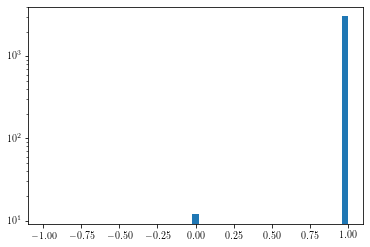

In [45]:
#showing tis different (nan's will be zero), we see that all are 1 or nan
plt.hist(np.nan_to_num(np.diag(corr_GWP_LU_process_level)), bins=np.linspace(-1,1,50))
plt.yscale('log')

In [61]:
del corr_GWP_LU_process_level

# Convergence

Check if the chains have converged by checking if the variation has stabelised

In [88]:
# Check this for f variable geography and variable price as there is the most variance in this set and possibilities (largest sample space)
LU = f['io_impacts/Land use'][()]

In [89]:
n_runs = LU.shape[0]
N_proc = sum(hdb.hybridized_processes_boolean_mask)

In [90]:
coeff = np.zeros((100, N_proc))
mean = np.zeros((100, N_proc))
for j,i in enumerate(np.linspace(100,n_runs,100, dtype='int')):
    std = np.std(LU[:i,hdb.hybridized_processes_boolean_mask], axis=0)
    mean_1 = np.mean(LU[:i,hdb.hybridized_processes_boolean_mask], axis=0)
    coeff[j,:] = std/mean_1
    mean[j,:] = mean_1

In [92]:
rMAD = np.zeros((100, N_proc))
median = np.zeros((100, N_proc))
for j,i in enumerate(np.linspace(100,n_runs,100, dtype='int')):
    MAD = scipy.stats.median_abs_deviation(LU[:i,hdb.hybridized_processes_boolean_mask], axis=0)
    median_1 = np.median(LU[:i,hdb.hybridized_processes_boolean_mask], axis=0)
    rMAD[j,:] = MAD/median_1
    median[j,:] = median_1

In [80]:
np.linspace(100,n_runs,100, dtype='int')

array([  100,   200,   300,   400,   500,   600,   700,   800,   900,
        1000,  1100,  1200,  1300,  1400,  1500,  1600,  1700,  1800,
        1900,  2000,  2100,  2200,  2300,  2400,  2500,  2600,  2700,
        2800,  2900,  3000,  3100,  3200,  3300,  3400,  3500,  3600,
        3700,  3800,  3900,  4000,  4100,  4200,  4300,  4400,  4500,
        4600,  4700,  4800,  4900,  5000,  5100,  5200,  5300,  5400,
        5500,  5600,  5700,  5800,  5900,  6000,  6100,  6200,  6300,
        6400,  6500,  6600,  6700,  6800,  6900,  7000,  7100,  7200,
        7300,  7400,  7500,  7600,  7700,  7800,  7900,  8000,  8100,
        8200,  8300,  8400,  8500,  8600,  8700,  8800,  8900,  9000,
        9100,  9200,  9300,  9400,  9500,  9600,  9700,  9800,  9900,
       10000])

In [145]:
ids = np.random.randint(coeff.shape[1],size=10)

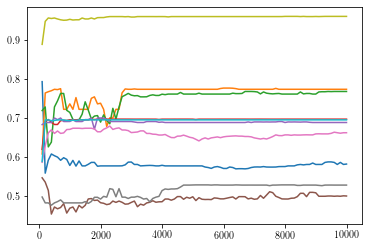

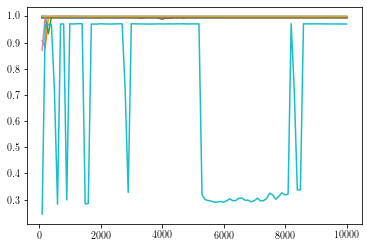

In [187]:
for id in ids:
    plt.plot(np.linspace(100,n_runs,100, dtype='int'), rMAD[:100,id])
plt.figure()
for id in ids_mad[:]:
    plt.plot(np.linspace(100,n_runs,100, dtype='int'), rMAD[:100,id])
#plt.ylim((0.98,1.01))

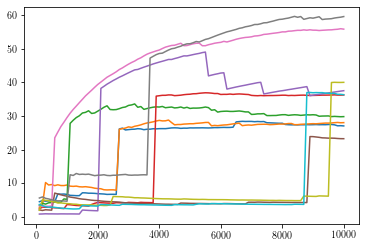

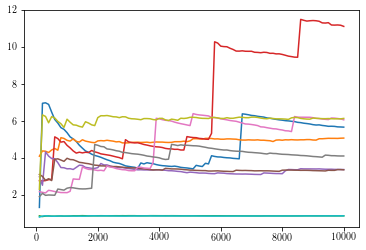

In [158]:
for id in ids:
    plt.plot(np.linspace(100,n_runs,100, dtype='int'), coeff[:100,id])
plt.figure()
for id in ids_mad:
    plt.plot(np.linspace(100,n_runs,100, dtype='int'), coeff[:100,id])

In [93]:
std_std = np.std(coeff[-30:,:], axis=0)
mean_std = np.mean(coeff[-30:,:], axis=0)
ids = np.argsort(np.nan_to_num(std_std))[-10:]
print(ids)

[1021 1182  524 1104 1348 1201  917 1277 1649 1016]


In [94]:
std_rMAD = np.std(rMAD[-30:,:], axis=0)
ids_mad = np.argsort(np.nan_to_num(std_rMAD))[-10:]
print(ids_mad)

[1615  667  308  624  922  321  811  731 1400 5083]


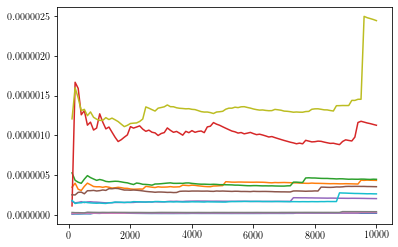

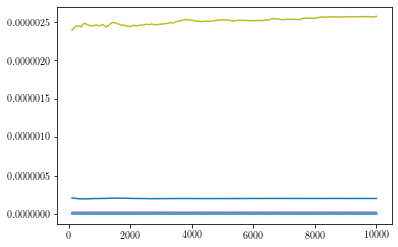

In [95]:
for id in ids:
    plt.plot(np.linspace(100,n_runs,100, dtype='int'), mean[:100,id])
plt.figure()
for id in ids_mad:
    plt.plot(np.linspace(100,n_runs,100, dtype='int'), mean[:100,id])

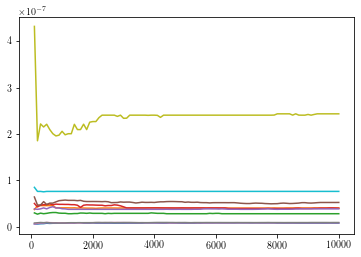

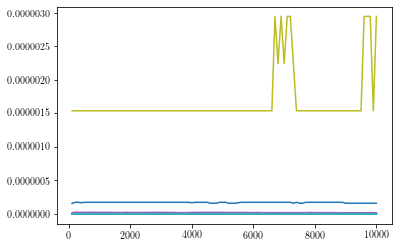

In [96]:
for id in ids:
    plt.plot(np.linspace(100,n_runs,100, dtype='int'), median[:100,id])
plt.figure()
for id in ids_mad:
    plt.plot(np.linspace(100,n_runs,100, dtype='int'), median[:100,id])

In [188]:
hdb.PRO.index.values[hdb.hybridized_processes_boolean_mask][5083]

'f7b5712e-8da2-4b82-8e1a-a1765416c897_659981bd-1a5f-4e8c-8208-6e0e7f935332'

In [189]:
hdb.PRO.loc['f7b5712e-8da2-4b82-8e1a-a1765416c897_659981bd-1a5f-4e8c-8208-6e0e7f935332']

activityId                            f7b5712e-8da2-4b82-8e1a-a1765416c897
productId                             659981bd-1a5f-4e8c-8208-6e0e7f935332
activityName                       transport, pipeline, onshore, petroleum
ISIC                                           4930:Transport via pipeline
price                                                            0.0054984
priceUnit                                                          EUR2005
EcoSpoldCategory                                            oil/production
geography                                                              RoW
technologyLevel                                                    Current
macroEconomicScenario                                    Business-as-Usual
productionVolume                                                   2.67763
productName                        transport, pipeline, onshore, petroleum
unitName                                                     metric ton*km
cpc                      

In [192]:
hdb.price_dict['f7b5712e-8da2-4b82-8e1a-a1765416c897_659981bd-1a5f-4e8c-8208-6e0e7f935332']

{'pricesByCountry': {'BR': {'price_sample': array([0.00566062, 0.0054373 , 0.00544549, ..., 0.00548262, 0.0053607 ,
          0.00537026])},
  'IN': {'price_sample': array([0.00566062, 0.0054373 , 0.00544549, ..., 0.00548262, 0.0053607 ,
          0.00537026])},
  'AU': {'price_sample': array([0.00566062, 0.0054373 , 0.00544549, ..., 0.00548262, 0.0053607 ,
          0.00537026])},
  'KR': {'price_sample': array([0.00566062, 0.0054373 , 0.00544549, ..., 0.00548262, 0.0053607 ,
          0.00537026])},
  'TR': {'price_sample': array([0.00566062, 0.0054373 , 0.00544549, ..., 0.00548262, 0.0053607 ,
          0.00537026])},
  'ZA': {'price_sample': array([0.00566062, 0.0054373 , 0.00544549, ..., 0.00548262, 0.0053607 ,
          0.00537026])},
  'US': {'price_sample': array([0.00566062, 0.0054373 , 0.00544549, ..., 0.00548262, 0.0053607 ,
          0.00537026])},
  'RU': {'price_sample': array([0.00566062, 0.0054373 , 0.00544549, ..., 0.00548262, 0.0053607 ,
          0.00537026])},
  'CA

So taking the most extreme cases, there seems to be still a relatively big jumps in the CoV. In the rMAD it seems only to be the case for 1 process. Let's also check how this is for the total swiss consumption to see if that impact converges. 

In [215]:
df = pd.DataFrame([hdb.price_dict['f7b5712e-8da2-4b82-8e1a-a1765416c897_659981bd-1a5f-4e8c-8208-6e0e7f935332']['regions'],hdb.price_dict['f7b5712e-8da2-4b82-8e1a-a1765416c897_659981bd-1a5f-4e8c-8208-6e0e7f935332']['region_weights']]).T
df.columns=['regions', 'pV']
df

,regions,pV
0,AT,0
1,BE,0
2,BG,0
3,CY,0
4,CZ,0
5,DE,0
6,DK,0
7,EE,0
8,ES,0
9,FI,0


In [ ]:
px.bar(df, x='regions', y='pV')


In [166]:
LU_CHHH = Land_Use_CH_HH_Var_Var.sum(axis=1)

In [194]:
coeff_CHHH = np.zeros(100)
for j,i in enumerate(np.linspace(100,n_runs,100, dtype='int')):
    std = np.std(LU_CHHH[:i], axis=0)
    mean = np.mean(LU_CHHH[:i], axis=0)
    coeff_CHHH[j] = std/mean
    
rMAD_CHHH = np.zeros(100)
for j,i in enumerate(np.linspace(100,n_runs,100, dtype='int')):
    MAD = scipy.stats.median_abs_deviation(LU_CHHH[:i], axis=0)
    median = np.median(LU_CHHH[:i], axis=0)
    rMAD_CHHH[j] = MAD/median

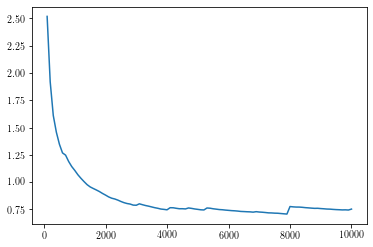

In [195]:
plt.plot(np.linspace(100,n_runs,100, dtype='int'), coeff_CHHH)

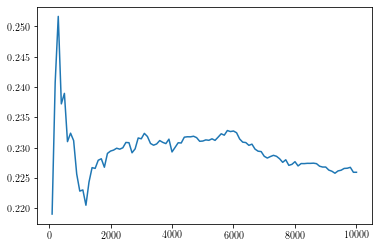

In [196]:
plt.plot(np.linspace(100,n_runs,100, dtype='int'), rMAD_CHHH)

In [178]:
ids_mad = np.argsort(np.nan_to_num(std_rMAD))[-20:]

In [201]:
mean = np.zeros(100)
median = np.zeros(100)
for j,i in enumerate(np.linspace(100,n_runs,100, dtype='int')):
    m = np.mean(LU_CHHH[:i], axis=0)
    md = np.median(LU_CHHH[:i], axis=0)
    mean[j] = m
    median[j] = md

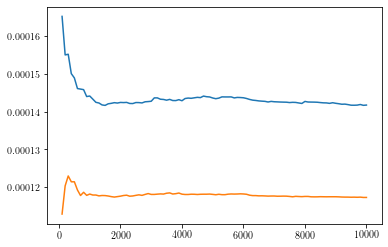

In [202]:
plt.plot(np.linspace(100,n_runs,100, dtype='int'), mean)
plt.plot(np.linspace(100,n_runs,100, dtype='int'), median)

In [39]:
14/(1144+96)

0.01129032258064516

In [146]:
from scipy.stats import dirichlet

In [147]:
import corner

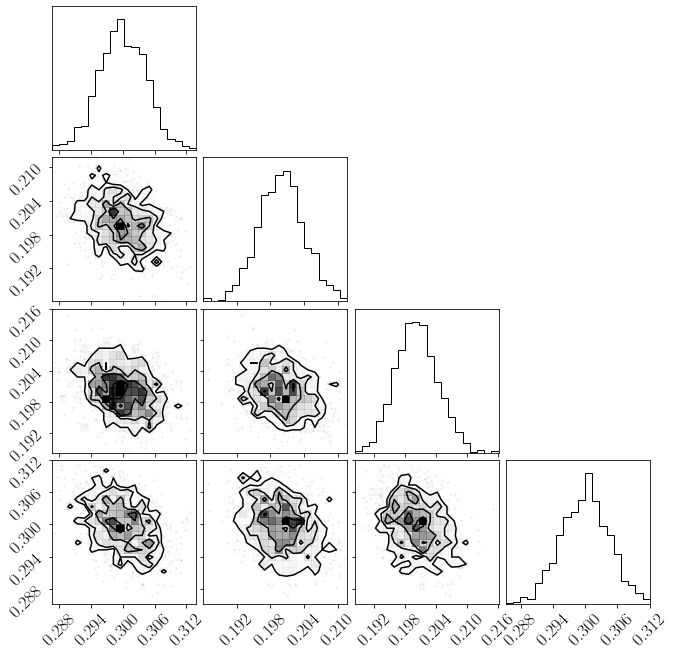

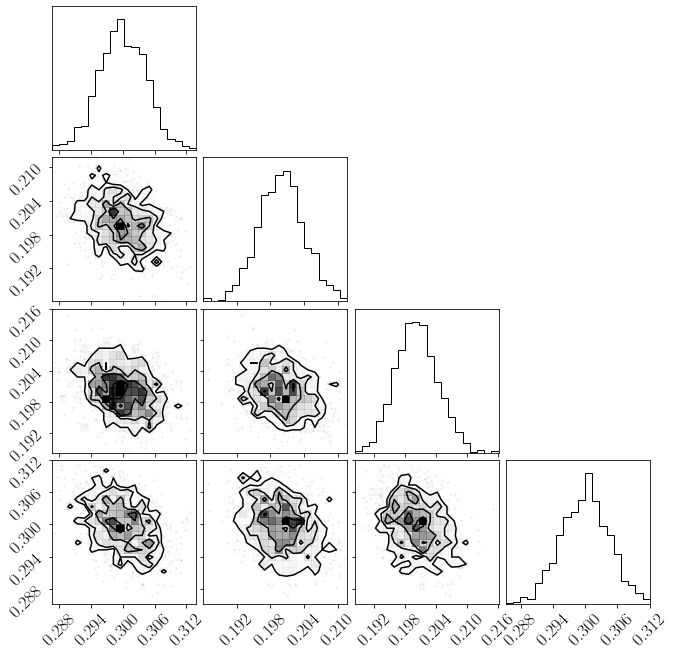

In [151]:
corner.corner(dirichlet.rvs(np.array([3,2,2,3])/0.001, size=1000))

In [266]:
[print(i[0],i[1][0],'\n') for i in hdb.PRO[['cpc','geography']].groupby('geography').count().iterrows()]

AE 5 

AL 21 

AM 6 

AO 5 

AR 24 

ASCC 25 

AT 72 

AU 55 

AZ 6 

BA 36 

BD 5 

BE 73 

BG 62 

BH 6 

BJ 6 

BN 5 

BO 5 

BR 88 

BW 6 

BY 8 

CA 13 

CA-AB 49 

CA-BC 23 

CA-MB 24 

CA-NB 37 

CA-NF 13 

CA-NS 37 

CA-NT 20 

CA-NU 10 

CA-ON 39 

CA-PE 33 

CA-QC 390 

CA-SK 25 

CA-YK 16 

CD 6 

CENTREL 1 

CG 6 

CH 1621 

CI 13 

CL 33 

CM 6 

CN 100 

CN-AH 14 

CN-BJ 14 

CN-CQ 14 

CN-FJ 13 

CN-GD 20 

CN-GS 14 

CN-GX 14 

CN-GZ 11 

CN-HA 14 

CN-HB 15 

CN-HE 15 

CN-HL 14 

CN-HN 15 

CN-HU 14 

CN-JL 14 

CN-JS 17 

CN-JX 13 

CN-LN 16 

CN-NM 14 

CN-NX 14 

CN-QH 14 

CN-SA 14 

CN-SC 14 

CN-SD 15 

CN-SH 18 

CN-SX 14 

CN-TJ 14 

CN-XJ 14 

CN-XZ 11 

CN-YN 14 

CN-ZJ 16 

CO 26 

CR 13 

CSG 6 

CU 5 

CW 5 

CY 30 

CZ 66 

Canada without Quebec 8 

DE 190 

DK 57 

DO 5 

DZ 13 

EC 18 

EE 42 

EG 5 

ENTSO-E 3 

ER 5 

ES 93 

ET 5 

Europe without Switzerland 312 

Europe, without Russia and Turkey 8 

FI 70 

FR 111 

FRCC 30 

GA 6 

GB 72 

GE 6 


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
f['io_impacts/']

In [25]:
hdb.PRO.loc[section1_bool_mask, ['activityName', 'geography', 'productName']]

,activityName,geography,productName
3c10ba7a-c90b-45d6-932b-4b5b54b09d4e_3cffc0cb-7f0f-41f1-b467-1a7f40fc45ec,hard coal mine operation,IN,"hard coal, run-of-mine"
237ae40c-de7b-42f2-abcc-f45b0a90e976_0d3eda5a-4601-4573-9549-0701c459ab88,hard coal mine operation and hard coal prepara...,"Europe, without Russia and Turkey",hard coal
e23b0dd7-7087-41d7-a873-04a15f08f544_0d3eda5a-4601-4573-9549-0701c459ab88,hard coal mine operation and hard coal prepara...,RU,hard coal
dcfb6365-7210-49d0-a73c-d0e636faf984_0d3eda5a-4601-4573-9549-0701c459ab88,hard coal mine operation and hard coal prepara...,RLA,hard coal
e65a8015-33c4-4210-94e6-0270c72606ea_0d3eda5a-4601-4573-9549-0701c459ab88,hard coal mine operation and hard coal prepara...,RNA,hard coal
...,...,...,...
ceb9aacb-c26f-47d9-b991-bc4d1dcbe0e2_66c93e71-f32b-4591-901c-55395db5c132,"electricity, high voltage, production mix",TZ,"electricity, high voltage"
009f8137-50dd-40ae-bd2e-16e7e40f4199_66c93e71-f32b-4591-901c-55395db5c132,"electricity, high voltage, production mix",CN-JX,"electricity, high voltage"
efa8a6fa-85a6-4b57-ab06-3558c248691f_66c93e71-f32b-4591-901c-55395db5c132,"electricity, high voltage, production mix",LT,"electricity, high voltage"
15bfaad8-50aa-4d94-adc2-f642058397b4_66c93e71-f32b-4591-901c-55395db5c132,"electricity, high voltage, production mix",GB,"electricity, high voltage"


In [29]:
pd.set_option('display.max_rows', None)
hdb.PRO.loc[masklist[7], ['activityName', 'geography', 'productName']]

,activityName,geography,productName
3c10ba7a-c90b-45d6-932b-4b5b54b09d4e_3cffc0cb-7f0f-41f1-b467-1a7f40fc45ec,hard coal mine operation,IN,"hard coal, run-of-mine"
237ae40c-de7b-42f2-abcc-f45b0a90e976_0d3eda5a-4601-4573-9549-0701c459ab88,hard coal mine operation and hard coal prepara...,"Europe, without Russia and Turkey",hard coal
e23b0dd7-7087-41d7-a873-04a15f08f544_0d3eda5a-4601-4573-9549-0701c459ab88,hard coal mine operation and hard coal prepara...,RU,hard coal
dcfb6365-7210-49d0-a73c-d0e636faf984_0d3eda5a-4601-4573-9549-0701c459ab88,hard coal mine operation and hard coal prepara...,RLA,hard coal
96e03844-f6b6-417f-866c-1554f2b256f9_0d3eda5a-4601-4573-9549-0701c459ab88,hard coal mine operation and hard coal prepara...,RoW,hard coal
8e0ea3bb-87c5-40d5-bacc-6c3d467dc0f3_0d3eda5a-4601-4573-9549-0701c459ab88,hard coal mine operation and hard coal prepara...,CN,hard coal
bf1867b4-e379-4a85-8a54-efd155bf019d_0d3eda5a-4601-4573-9549-0701c459ab88,hard coal mine operation and hard coal prepara...,AU,hard coal
2f8fba79-3cfb-4612-ba00-75cd42ed8022_0d3eda5a-4601-4573-9549-0701c459ab88,hard coal mine operation and hard coal prepara...,ID,hard coal
fd751b34-dd49-4e1d-9f35-aef5d3d6188d_3cffc0cb-7f0f-41f1-b467-1a7f40fc45ec,"hard coal mine operation, open cast, dragline",ZA,"hard coal, run-of-mine"
42fa09df-f6f2-4d5e-88ce-7f2c5bec7dd8_3cffc0cb-7f0f-41f1-b467-1a7f40fc45ec,"hard coal mine operation, open cast, truck and...",ZA,"hard coal, run-of-mine"


In [30]:
pd.reset_option('display.max_rows')